<a href="https://colab.research.google.com/github/LinOna/agroforestry/blob/main/notebooks/Q1_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Setup for Q1: imports, config, robust detection, helpers (AR v006+)
# No seaborn. Pure pandas/numpy/matplotlib.

import os, re, math, random, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Config ----------
TIMEZONE_STR   = None     # e.g. "Europe/Berlin" or None to leave UTC
ROLL_WINDOW_DOY = 9       # smoothing window for seasonal curves (DOY units)
BOOTSTRAP_B     = 2000    # bootstrap reps for CI
PERM_REPS       = 2000    # permutation reps for p-values
RANDOM_SEED     = 123

# Optional default input (leave None if you load elsewhere)
AR_PATH = None  # e.g., "af_clean_v01/analysis_ready_v006.csv"

# ---------- Repro + warnings ----------
rng = np.random.default_rng(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
warnings.filterwarnings("ignore", message=".*DataFrameGroupBy.apply.*", category=FutureWarning)

# ---------- Site mapping ----------
SITE_MAP = {"agroforestry":"AF", "open_field":"Open", "reference":"reference"}

# ---------- Exact column preferences per variable (AR v006+) ----------
EXACT_PREF = {
    "air_temp":         ["temperature__pref"],
    "rh":               ["humidity__pref"],
    "wind_speed":       ["wind_speed_mean__pref", "wind_speed__pref"],
    "global_radiation": ["global_radiation__pref"],
    "air_pressure":     ["pressure__pref"],
    # soil_* combined below
}

# ---------- Fallback regex patterns (avoid QC/flags, avoid ground_* for RH) ----------
FALLBACK_PATTERNS = {
    "air_temp":         [r"\btemperature(__pref)?\b", r"\bair[_\s-]*temp"],
    "rh":               [r"(?<!ground_)\bhumidity(__pref)?\b", r"\brh\b"],  # negative lookbehind skips ground_humidity
    "wind_speed":       [r"wind[_\s-]*speed[_\s-]*mean(__pref)?", r"\bws_mean\b", r"\bws\b"],
    "global_radiation": [r"global[_\s-]*radiation(__pref)?", r"\brad(__pref)?\b", r"\bsw\b"],
    "air_pressure":     [r"\bpressure(__pref)?\b", r"\bpress\b"],
}

# ---------- Small utilities ----------
def rolling_smooth(series, window=9):
    s = pd.Series(series)
    return s.rolling(window=window, min_periods=max(1, window//2), center=True).mean()

def paired_permutation_pvalue(diffs, reps=PERM_REPS, seed=RANDOM_SEED):
    rng = np.random.default_rng(seed)
    diffs = np.asarray(diffs, dtype=float)
    diffs = diffs[~np.isnan(diffs)]
    n = diffs.size
    if n < 5:
        return np.nan
    T_obs = diffs.mean()
    signs = rng.choice([-1, 1], size=(reps, n))
    T_perm = (diffs * signs).mean(axis=1)
    p = (np.abs(T_perm) >= abs(T_obs)).mean()
    return (p * reps + 1) / (reps + 1)  # small-sample adj.

def benjamini_hochberg(pdict):
    items = [(k, v) for k, v in pdict.items() if np.isfinite(v)]
    m = len(items)
    if m == 0:
        return {k: np.nan for k in pdict}
    items.sort(key=lambda kv: kv[1])
    qvals = {}
    min_so_far = 1.0
    for rank, (name, p) in enumerate(reversed(items), start=1):
        i = m - rank + 1
        q = min(min_so_far, (m / i) * p)
        qvals[name] = q
        min_so_far = q
    return {k: qvals.get(k, np.nan) for k in pdict}

def compute_vpd_kpa(temp_c: pd.Series, rh_pct: pd.Series) -> pd.Series:
    """Tetens formula; returns VPD in kPa."""
    T  = pd.to_numeric(temp_c, errors="coerce")
    RH = pd.to_numeric(rh_pct, errors="coerce")
    es = 0.6108 * np.exp((17.27 * T) / (T + 237.3))  # saturation vapor pressure [kPa]
    vpd = es * (1.0 - (RH/100.0))
    return vpd.astype(float)

# ---------- Column pickers ----------
def _pick_col(df, exact=None, patterns=None, exclude_regex=None):
    cols = list(df.columns)
    # exact (strong preference)
    if exact:
        for n in exact:
            if n in df.columns:
                return n
    # regex fallback
    if patterns:
        cols_lc = {c: c.lower() for c in cols}
        for pat in patterns:
            rx = re.compile(pat)
            for c, lc in cols_lc.items():
                if exclude_regex and re.search(exclude_regex, lc):
                    continue
                # skip QC/flags
                if re.search(r'(^ok_|_ok$|^qc_|_qc$|_flag|_flags|_mask|_status|_cause)', lc):
                    continue
                if rx.search(lc):
                    return c
    return None

# ---------- Main AR preparer ----------
def prepare_ar_dataframe(df: pd.DataFrame, timezone_str: str | None = TIMEZONE_STR):
    cols = set(df.columns)

    # Time
    ts_col = "timestamp" if "timestamp" in cols else ("timestamp_iso" if "timestamp_iso" in cols else None)
    if ts_col:
        ts = pd.to_datetime(df[ts_col], errors="coerce", utc=True)
        if timezone_str:
            ts = ts.dt.tz_convert(timezone_str)
        df["_ts"]   = ts.dt.tz_localize(None)
        df["_date"] = df["_ts"].dt.date
        df["_doy"]  = df["_ts"].dt.dayofyear
    else:
        df["_ts"] = pd.NaT
        df["_date"] = pd.NaT
        df["_doy"] = np.nan

    # Site mapping
    site_col = "station_type" if "station_type" in cols else None
    if site_col:
        raw_site = df[site_col].astype(str).str.strip().str.lower()
        df["_site"] = raw_site.map(SITE_MAP).fillna(df[site_col])
    else:
        df["_site"] = np.nan

    # Distance (best-effort)
    dcol = next((c for c in ["_distance_m","distance_m","distance","dist_m"] if c in cols), None)
    if dcol:
        df["_distance_m"] = pd.to_numeric(df[dcol], errors="coerce")
    else:
        df["_distance_m"] = np.nan

    # Combined soil moisture & soil temperature from probes (prefer __pref)
    sm0 = pd.to_numeric(df.get("ground_humidity_0__pref"), errors="coerce")
    sm1 = pd.to_numeric(df.get("ground_humidity_1__pref"), errors="coerce")
    if ("ground_humidity_0__pref" in cols) or ("ground_humidity_1__pref" in cols):
        df["soil_moisture__pref"] = pd.concat([sm0, sm1], axis=1).mean(axis=1, skipna=True)

    st0 = pd.to_numeric(df.get("ground_temp_0__pref"), errors="coerce")
    st1 = pd.to_numeric(df.get("ground_temp_1__pref"), errors="coerce")
    if ("ground_temp_0__pref" in cols) or ("ground_temp_1__pref" in cols):
        df["soil_temp__pref"] = pd.concat([st0, st1], axis=1).mean(axis=1, skipna=True)

    # Detect variables, preferring __pref
    NUM_VARS = {}
    for key in ["air_temp","rh","wind_speed","global_radiation","air_pressure"]:
        NUM_VARS[key] = _pick_col(df,
                                  exact=EXACT_PREF.get(key),
                                  patterns=FALLBACK_PATTERNS.get(key),
                                  exclude_regex=(r"^ground_humidity" if key=="rh" else None))

    # Pin soil_* to combined features
    if "soil_moisture__pref" in df.columns:
        NUM_VARS["soil_moisture"] = "soil_moisture__pref"
    else:
        # fallback to single probe if needed
        for c in ["ground_humidity_0__pref","ground_humidity_1__pref"]:
            if c in cols: NUM_VARS["soil_moisture"] = c; break

    if "soil_temp__pref" in df.columns:
        NUM_VARS["soil_temp"] = "soil_temp__pref"
    else:
        for c in ["ground_temp_0__pref","ground_temp_1__pref"]:
            if c in cols: NUM_VARS["soil_temp"] = c; break

    # VPD: prefer existing; else compute if temp+RH present
    vpd_col = next((c for c in ["vpd__pref","vpd"] if c in cols), None)
    if vpd_col is None and NUM_VARS.get("air_temp") and NUM_VARS.get("rh"):
        df["vpd__pref"] = compute_vpd_kpa(df[NUM_VARS["air_temp"]], df[NUM_VARS["rh"]])
        vpd_col = "vpd__pref"
    if vpd_col:
        NUM_VARS["vpd"] = vpd_col

    # Report
    det = pd.DataFrame({"key": list(NUM_VARS.keys()),
                        "column_detected": [NUM_VARS[k] for k in NUM_VARS]})
    print("\nDetected columns:")
    print(det.to_string(index=False))

    if site_col:
        print("\nUnique site labels (raw -> mapped):")
        uni = (pd.DataFrame({"raw": df[site_col].astype(str).str.strip().str.lower(),
                             "mapped": df["_site"]})
               .drop_duplicates().reset_index(drop=True))
        print(uni)
    else:
        print("\n(no site column detected)")

    return df, NUM_VARS

# ---------- Optional: auto-load if AR_PATH is set ----------
if AR_PATH:
    _df = pd.read_csv(AR_PATH, low_memory=False)
    _df, _NUM_VARS = prepare_ar_dataframe(_df)
    print("\nReady: _df dataframe loaded and _NUM_VARS mapping built.")
    # You can now use: _NUM_VARS["air_temp"], _NUM_VARS["soil_moisture"], etc.


In [2]:
# @title Upload CSV directly (alternative to Drive)
from google.colab import files
up = files.upload()  # choose your CSV
CSV_PATH = list(up.keys())[0]
df = pd.read_csv(CSV_PATH, low_memory=False)
print("Rows:", len(df), "Columns:", len(df.columns))
df.head(3)

Saving analysis_ready_v006.csv to analysis_ready_v006 (1).csv
Rows: 483787 Columns: 105


,row_id,node_id,node,station_type,ts_ns,timestamp_iso,timestamp,ground_humidity_0__pref,ground_humidity_1__pref,ground_temp_0__pref,...,wind_speed_max,pressure,ground_temp_0,global_radiation,temperature,humidity,wind_speed_min,ground_temp_1,ground_humidity_1,wind_speed_mean
0,483783,node_176,node_176,open_field,1698668569000000000,2023-10-30 12:22:49,2023-10-30 12:22:49+00:00,4.56,9.61,9.63,...,7.57,1000.0,9.63,244.0,15.3,71.1,3.42,8.65,9.61,5.65
1,483776,node_176,node_176,open_field,1698669485000000000,2023-10-30 12:38:05,2023-10-30 12:38:05+00:00,4.32,9.37,9.63,...,11.70,1000.0,9.63,412.0,16.6,69.0,4.76,8.65,9.37,7.97
2,483768,node_176,node_176,open_field,1698670401000000000,2023-10-30 12:53:21,2023-10-30 12:53:21+00:00,4.48,9.20,9.14,...,11.50,1000.0,9.14,331.0,16.2,67.7,3.05,9.14,9.20,6.92


In [3]:
df.shape

(483787, 105)

In [4]:
import pandas as pd
pd.set_option("display.max_rows", None)  # show all rows in the table
cols_info = pd.DataFrame({"column": df.columns, "dtype": df.dtypes.astype(str)})
cols_info.reset_index(drop=True)

,column,dtype
0,row_id,int64
1,node_id,object
2,node,object
3,station_type,object
4,ts_ns,int64
5,timestamp_iso,object
6,timestamp,object
7,ground_humidity_0__pref,float64
8,ground_humidity_1__pref,float64
9,ground_temp_0__pref,float64


In [6]:
# alternative upload
#import pandas as pd

#CSV_PATH = "/content/analysis_ready_v001.csv"  # ← rename to your uploaded filename
#df = pd.read_csv(CSV_PATH, low_memory=False)
#print("Loaded:", CSV_PATH, df.shape)

FileNotFoundError: [Errno 2] No such file or directory: '/content/analysis_ready_v001.csv'

In [7]:
# --- Step 2 (ALT): Explicit mapping for your dataset schema (AR v006+) ---

# 1) Tell the pipeline which columns are timestamp/site
COL_TIMESTAMP = "timestamp_iso"      # you also have "timestamp"; either works
COL_SITE      = "station_type"       # values: open_field, agroforestry, reference
COL_DISTANCE  = None                 # not needed for Q1

# 2) Map raw site labels → AF/Open (exclude 'reference' later)
SITE_MAP_HINTS = {
    "open_field":  "Open",
    "agroforestry":"AF",
    "reference":   "Reference",
    # also catch looser hints, just in case:
    "open":        "Open",
    "agro":        "AF",
    "af":          "AF",
}

def col_exists(name): return (name is not None) and (name in df.columns)

def choose_first(*candidates):
    for c in candidates:
        if col_exists(c):
            return c
    return None

def _site_label(raw, hints):
    if pd.isna(raw): return np.nan
    s = str(raw).strip().lower()
    for key, val in hints.items():
        if key in s:
            return val
    return raw

# in case the earlier setup cell didn't define this:
if "_to_local_naive" not in globals():
    def _to_local_naive(ts, tz):
        s = pd.to_datetime(ts, errors='coerce', utc=True)
        if tz:
            try:
                s = s.dt.tz_convert(tz)
            except Exception:
                s = pd.to_datetime(ts, errors='coerce').dt.tz_localize(tz, nonexistent='shift_forward', ambiguous='NaT')
        return s.dt.tz_localize(None)

# 3) Build var_map explicitly for this dataset (prefer __pref, then _clean, then raw)

var_map = {}

# Air temperature
var_map["air_temp"] = choose_first("temperature__pref", "temperature")

# Air relative humidity (ONLY air humidity, not soil!)
var_map["rh"] = choose_first("humidity__pref", "humidity")

# VPD: compute later from air_temp + rh if missing
var_map["vpd"] = None

# Wind speed (use mean)
var_map["wind_speed"] = choose_first("wind_speed_mean__pref", "wind_speed_mean_clean", "wind_speed_mean")

# Wind direction (excluded from stats for Q1 if present)
var_map["wind_dir"] = choose_first("wind_dir__pref", "wind_dir")

# Global radiation
var_map["global_radiation"] = choose_first("global_radiation__pref", "global_radiation_clean", "global_radiation")

# Soil moisture (two probes, prefer preferred/clean/raw)
var_map["soil_moisture_0"] = choose_first("ground_humidity_0__pref", "ground_humidity_0_clean", "ground_humidity_0")
var_map["soil_moisture_1"] = choose_first("ground_humidity_1__pref", "ground_humidity_1_clean", "ground_humidity_1")

# Soil temperature (two probes, prefer preferred/clean/raw)
var_map["soil_temp_0"] = choose_first("ground_temp_0__pref", "ground_temp_0_clean", "ground_temp_0")
var_map["soil_temp_1"] = choose_first("ground_temp_1__pref", "ground_temp_1_clean", "ground_temp_1")

# Also provide combined soil variables (row-wise mean of available probes)
if any(col_exists(c) for c in ["ground_humidity_0__pref","ground_humidity_1__pref",
                                "ground_humidity_0_clean","ground_humidity_1_clean",
                                "ground_humidity_0","ground_humidity_1"]):
    sm0 = pd.to_numeric(df.get(var_map["soil_moisture_0"]), errors="coerce") if var_map["soil_moisture_0"] else np.nan
    sm1 = pd.to_numeric(df.get(var_map["soil_moisture_1"]), errors="coerce") if var_map["soil_moisture_1"] else np.nan
    df["soil_moisture__pref"] = pd.concat([pd.Series(sm0), pd.Series(sm1)], axis=1).mean(axis=1, skipna=True)
    var_map["soil_moisture"] = "soil_moisture__pref"

if any(col_exists(c) for c in ["ground_temp_0__pref","ground_temp_1__pref",
                                "ground_temp_0_clean","ground_temp_1_clean",
                                "ground_temp_0","ground_temp_1"]):
    st0 = pd.to_numeric(df.get(var_map["soil_temp_0"]), errors="coerce") if var_map["soil_temp_0"] else np.nan
    st1 = pd.to_numeric(df.get(var_map["soil_temp_1"]), errors="coerce") if var_map["soil_temp_1"] else np.nan
    df["soil_temp__pref"] = pd.concat([pd.Series(st0), pd.Series(st1)], axis=1).mean(axis=1, skipna=True)
    var_map["soil_temp"] = "soil_temp__pref"

# --- Standardize core fields using your chosen columns ---
if COL_TIMESTAMP is None:
    raise ValueError("Set COL_TIMESTAMP above.")
df["_ts"] = _to_local_naive(df[COL_TIMESTAMP], TIMEZONE_STR)
df["_date"] = pd.to_datetime(df["_ts"]).dt.date
df["_doy"]  = pd.to_datetime(df["_ts"]).dt.dayofyear

if COL_SITE is None:
    raise ValueError("Set COL_SITE above.")
df["_site_raw"] = df[COL_SITE]
df["_site"] = df[COL_SITE].apply(lambda s: _site_label(s, SITE_MAP_HINTS))

# distance not needed for Q1
df["_distance_m"] = np.nan

# Compute VPD if we have temp + RH
if var_map["vpd"] is None and var_map["air_temp"] and var_map["rh"]:
    T  = pd.to_numeric(df[var_map["air_temp"]], errors="coerce")
    RH = pd.to_numeric(df[var_map["rh"]], errors="coerce")
    es = 0.6108 * np.exp((17.27 * T) / (T + 237.3))  # kPa
    df["_vpd_calc"] = es * (1.0 - RH/100.0)
    var_map["vpd"] = "_vpd_calc"

# Report what we’ll use
detected = pd.DataFrame(
    [("timestamp", COL_TIMESTAMP), ("site", COL_SITE), ("distance", COL_DISTANCE)] +
    [(k, v) for k, v in var_map.items()],
    columns=["key", "column_used"]
)
display(detected)

print("\nUnique site labels (raw → mapped):")
display(pd.DataFrame({"raw": df["_site_raw"].astype(str).unique()}).assign(
    mapped=lambda d: d["raw"].apply(lambda s: _site_label(s, SITE_MAP_HINTS))
))


,key,column_used
0,timestamp,timestamp_iso
1,site,station_type
2,distance,None
3,air_temp,temperature__pref
4,rh,humidity__pref
5,vpd,_vpd_calc
6,wind_speed,wind_speed_mean__pref
7,wind_dir,None
8,global_radiation,global_radiation__pref
9,soil_moisture_0,ground_humidity_0__pref



Unique site labels (raw → mapped):


,raw,mapped
0,open_field,Open
1,agroforestry,AF
2,reference,Reference


In [8]:
# @title Daily means by site (for pairing AF vs Open)

# 1) Keep AF/Open only if present in reasonable numbers; else keep all
mask_known = df["_site"].astype(str).isin(["AF", "Open"])
df_use = df.loc[mask_known].copy() if mask_known.sum() >= 100 else df.copy()

# 2) Variables to aggregate: take columns from var_map (exclude None and wind_dir)
use_cols = [col for k, col in var_map.items() if (col is not None and k != "wind_dir")]
use_cols = sorted(dict.fromkeys(use_cols))  # unique, stable order

# 3) Ensure datetime day key
df_use["_date"] = pd.to_datetime(df_use["_ts"], errors="coerce").dt.floor("D")

# 4) Coerce chosen columns to numeric (others untouched)
for col in use_cols:
    df_use[col] = pd.to_numeric(df_use[col], errors="coerce")

# 5) Daily means by site (numeric-only)
daily = (
    df_use[["_date", "_site"] + use_cols]
    .groupby(["_date", "_site"], dropna=False, as_index=False)
    .mean(numeric_only=True)
)

# 6) Quick look
display(daily.head())
print("Daily rows per site:")
display(daily["_site"].value_counts(dropna=False).to_frame("rows"))

# 7) Coverage snapshot (share of non-missing per site across all days)
cov = (
    df_use.groupby("_site")[use_cols]
    .apply(lambda g: g.notna().mean().rename("non_null_share"))
    .unstack(0)
    .round(3)
)
print("Non-null share by variable and site (0–1):")
display(cov)

# 8) Save (optional)
DAILY_OUT = "q1_daily_means_by_site.csv"
daily.to_csv(DAILY_OUT, index=False)
print("Saved:", DAILY_OUT)


,_date,_site,_vpd_calc,global_radiation__pref,ground_humidity_0__pref,ground_humidity_1__pref,ground_temp_0__pref,ground_temp_1__pref,humidity__pref,soil_moisture__pref,soil_temp__pref,temperature__pref,wind_speed_mean__pref
0,2023-10-30,AF,0.264380,84.374964,7.614783,6.578188,9.985761,9.960688,82.919565,7.096486,9.973225,12.617065,2.147246
1,2023-10-30,Open,0.261278,89.004348,4.481739,9.369348,10.010870,9.466739,82.426087,6.925543,9.738804,12.307174,3.135217
2,2023-10-31,AF,0.204737,89.608233,7.584894,6.466148,9.930336,9.763993,84.923852,7.025521,9.847164,11.281307,4.584717
3,2023-10-31,Open,0.189150,91.515957,4.250957,9.233830,9.967553,9.423617,85.443617,6.742394,9.695585,10.748511,9.255745
4,2023-11-01,AF,0.264298,69.789208,7.377591,6.173333,9.654092,9.345446,77.701650,6.775462,9.499769,9.044785,2.425083


Daily rows per site:


,rows
_site,
AF,672
Open,531


Non-null share by variable and site (0–1):


non_null_share           _site
_vpd_calc                AF       0.387
                         Open     0.851
global_radiation__pref   AF       0.998
                         Open     1.000
ground_humidity_0__pref  AF       0.900
                         Open     0.993
ground_humidity_1__pref  AF       0.940
                         Open     0.993
ground_temp_0__pref      AF       0.880
                         Open     0.961
ground_temp_1__pref      AF       0.919
                         Open     0.947
humidity__pref           AF       0.387
                         Open     0.852
soil_moisture__pref      AF       0.982
                         Open     0.993
soil_temp__pref          AF       0.976
                         Open     0.977
temperature__pref        AF       0.976
                         Open     0.980
wind_speed_mean__pref    AF       1.000
                         Open     1.000
dtype: float64

Saved: q1_daily_means_by_site.csv


In [26]:
# --- Verify current 'daily' vs node-equal daily with probe composites ---

# 0) basics
NODE_COL = "node" if "node" in df.columns else ("node_id" if "node_id" in df.columns else None)
assert NODE_COL is not None, "Need a node column ('node' or 'node_id')."

# 1) which soil columns exist in your var_map?
sm0 = var_map.get("soil_moisture_0")
sm1 = var_map.get("soil_moisture_1")
st0 = var_map.get("soil_temp_0")
st1 = var_map.get("soil_temp_1")

# 2) build a working set of numeric columns you currently aggregate
use_cols = [col for k,col in var_map.items() if (col is not None and k != "wind_dir")]
use_cols = sorted(dict.fromkeys(use_cols))
for c in use_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# 3) make per-node daily means first (so each node contributes once per day)
df["_date"] = pd.to_datetime(df["_ts"], errors="coerce").dt.floor("D")
daily_node = (
    df.groupby(["_date", "_site", NODE_COL], dropna=False)[use_cols]
      .mean()
      .reset_index()
)

# 4) make node-level COMPOSITES for soil moisture/temp (robust mean of _0/_1)
def _rowwise_composite(frame, cols, gate=None):
    """row-wise mean across listed columns; optionally drop if probes disagree too much."""
    if not cols or len(cols) == 0:
        return pd.Series(index=frame.index, dtype="float64")
    arr = frame[cols].astype(float).to_numpy()
    if gate is not None and len(cols) == 2:
        diff = np.abs(arr[:,0] - arr[:,1])
        mask = np.isfinite(diff) & (diff > gate)
        arr[mask,:] = np.nan  # kill both when they wildly disagree
    return np.nanmean(arr, axis=1)

comp_cols = {}
if sm0 and sm1 and sm0 in daily_node and sm1 in daily_node:
    daily_node["_soil_moisture_node"] = _rowwise_composite(daily_node, [sm0, sm1], gate=0.05)
    comp_cols["soil_moisture"] = "_soil_moisture_node"
if st0 and st1 and st0 in daily_node and st1 in daily_node:
    daily_node["_soil_temp_node"] = _rowwise_composite(daily_node, [st0, st1], gate=1.0)
    comp_cols["soil_temp"] = "_soil_temp_node"

# 5) node-equal site daily means (mean across nodes, not across rows)
daily_equal_weight = (
    daily_node.groupby(["_date", "_site"], dropna=False)[daily_node.columns.difference([NODE_COL, "_site", "_date"])]
              .mean()
              .reset_index()
)

# 6) compare your current 'daily' (row-mean) vs node-equal for overlapping columns
def _matchable_cols(d1, d2):
    return sorted(set(d1.columns) & set(d2.columns) - {"_date","_site"})

joined = daily.merge(daily_equal_weight, on=["_date","_site"], how="inner", suffixes=("_rowmean","_nodeeq"))
common = _matchable_cols(daily, daily_equal_weight)

report = []
for c in common:
    a = pd.to_numeric(joined.get(f"{c}_rowmean"), errors="coerce")
    b = pd.to_numeric(joined.get(f"{c}_nodeeq"), errors="coerce")
    ok = a.notna() & b.notna()
    if ok.any():
        mae = float(np.nanmean(np.abs(a[ok] - b[ok])))
        rmse = float(np.sqrt(np.nanmean((a[ok] - b[ok])**2)))
        report.append((c, ok.sum(), mae, rmse))
report_df = pd.DataFrame(report, columns=["column","n_days","MAE","RMSE"]).sort_values("MAE", ascending=False)
print("Row-mean vs Node-equal differences (absolute units):")
display(report_df.head(20))

# 7) sanity statements about whether you're currently compositing & node-equal weighting
is_doing_composite = ("soil_moisture" in var_map) or ("soil_temp" in var_map)
doing_node_equal = False  # with your pasted code, this is False

print(f"Composite in your current pipeline? {is_doing_composite}")
print(f"Node-equal weighting in your current pipeline? {doing_node_equal}")

# (Optional) If you want to switch the rest of the notebook to the node-equal version:
# daily = daily_equal_weight.copy()
# and for soil plots prefer the composite columns:
# var_map["soil_moisture"] = comp_cols.get("soil_moisture", var_map.get("soil_moisture"))
# var_map["soil_temp"]     = comp_cols.get("soil_temp",     var_map.get("soil_temp"))


Row-mean vs Node-equal differences (absolute units):


/tmp/ipython-input-31671592.py:37: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr, axis=1)
/tmp/ipython-input-31671592.py:37: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr, axis=1)


,column,n_days,MAE,RMSE
6,humidity__pref,1135,1.504878,2.835469
1,global_radiation__pref,1203,1.181226,4.684211
2,ground_humidity_0__pref,1201,0.111124,0.419239
3,ground_humidity_1__pref,1201,0.076607,0.249595
7,soil_moisture__pref,1201,0.073457,0.265106
5,ground_temp_1__pref,1193,0.066557,0.322118
4,ground_temp_0__pref,1194,0.048090,0.266758
8,soil_temp__pref,1198,0.042663,0.229814
9,temperature__pref,1193,0.033735,0.248658
0,_vpd_calc,1134,0.031898,0.067115


Composite in your current pipeline? True
Node-equal weighting in your current pipeline? False


In [27]:
# Quick imbalance diagnostic: how much does the chattiest node dominate each site/day?
tmp = (
    df.assign(_date=pd.to_datetime(df["_ts"], errors="coerce").dt.floor("D"))
      .groupby(["_date", "_site", "node"], dropna=False)["row_id"].count()
      .rename("n").reset_index()
)

dom = (
    tmp.groupby(["_date","_site"], dropna=False)["n"]
       .apply(lambda s: s.max() / s.sum() if s.sum() else float("nan"))
       .rename("max_node_share").reset_index()
)

print(dom["max_node_share"].describe())
print("Days with a single node ≥50% of rows:", int((dom["max_node_share"] >= 0.5).sum()))


count    1608.000000
mean        0.660159
std         0.407038
min         0.142857
25%         0.169065
50%         1.000000
75%         1.000000
max         1.000000
Name: max_node_share, dtype: float64
Days with a single node ≥50% of rows: 958


In [24]:
# === Year check using ONLY months common to all observed years (AF vs Open) ===
import numpy as np
import pandas as pd
import os

# ---- defaults if your setup cell wasn't run (safe no-ops if already defined) ----
RANDOM_SEED = globals().get("RANDOM_SEED", 123)
BOOTSTRAP_B = globals().get("BOOTSTRAP_B", 2000)
PERM_REPS   = globals().get("PERM_REPS", 2000)

rng = np.random.default_rng(RANDOM_SEED)

# Small helpers (re-use if already defined)
def paired_permutation_pvalue(diffs, reps=2000, seed=123):
    r = np.random.default_rng(seed)
    d = np.asarray(diffs, dtype=float)
    d = d[~np.isnan(d)]
    n = d.size
    if n < 5:
        return np.nan
    T_obs = d.mean()
    signs = r.choice([-1, 1], size=(reps, n))
    T_perm = (d * signs).mean(axis=1)
    p = (np.abs(T_perm) >= abs(T_obs)).mean()
    return (p * reps + 1) / (reps + 1)  # small-sample adj

def _ci_bootstrap_mean(vals, B=2000, seed=123, q=(2.5, 97.5)):
    v = np.asarray(vals, dtype=float)
    v = v[~np.isnan(v)]
    n = v.size
    if n == 0:
        return (np.nan, np.nan)
    r = np.random.default_rng(seed)
    idx = r.integers(0, n, size=(B, n))
    m = v[idx].mean(axis=1)
    return tuple(np.percentile(m, list(q)))

# ---- restrict daily to AF/Open and compute months common to ALL observed years ----
d0 = daily.copy()
d0["_date"] = pd.to_datetime(d0["_date"])
d0 = d0[d0["_site"].isin(["AF", "Open"])].copy()

_by = d0.assign(month=d0["_date"].dt.month, year=d0["_date"].dt.year)
years = sorted(_by["year"].unique().tolist())
if len(years) < 2:
    print("[year-check] Only one observed year after AF/Open filter — heterogeneity test skipped.")

common_months = None
if len(years) >= 1:
    month_sets = [set(_by.loc[_by["year"] == y, "month"].unique()) for y in years]
    common_months = set.intersection(*month_sets) if month_sets else set()

if not common_months:
    print("[year-check] No months overlap across years; using full daily (no overlap filter).")
    daily_overlap = d0.copy()
else:
    daily_overlap = _by[_by["month"].isin(common_months)].drop(columns=["month","year"]).copy()
    print(f"[year-check] Months used across ALL years: {sorted(common_months)}")

# ---- core routine: per-variable per-year summaries + across-year heterogeneity ----
out_rows_per_year = []
out_rows_overall  = []

# Map var keys -> column names present in daily
VAR_KEYS = [k for k in NUM_VARS.keys()]  # use all detected variables
print(f"[year-check] Variables considered: {VAR_KEYS}")

for var_key in VAR_KEYS:
    col = NUM_VARS[var_key]
    if col not in daily_overlap.columns:
        continue

    # (1) build daily paired AF/Open differences per year
    piv = (
        daily_overlap
        .pivot_table(index="_date", columns="_site", values=col, aggfunc="mean")
        .dropna(subset=["AF","Open"])
        .assign(year=lambda x: x.index.year)
    )
    if piv.empty:
        continue

    # Overall pooled diffs (across years with overlap months)
    diffs_all = (piv["AF"] - piv["Open"]).values
    overall_mean = float(np.nanmean(diffs_all))
    overall_ci_lo, overall_ci_hi = _ci_bootstrap_mean(diffs_all, B=BOOTSTRAP_B, seed=RANDOM_SEED)
    overall_p = paired_permutation_pvalue(diffs_all, reps=PERM_REPS, seed=RANDOM_SEED)

    out_rows_overall.append({
        "variable": var_key,
        "months_used": ",".join(map(str, sorted(common_months))) if common_months else "ALL",
        "n_years": int(piv["year"].nunique()),
        "n_days_total": int(np.isfinite(diffs_all).sum()),
        "mean_diff_AF_minus_Open": overall_mean,
        "ci95_lo": overall_ci_lo,
        "ci95_hi": overall_ci_hi,
        "p_perm_overall": overall_p,
    })

    # (2) per-year summaries
    for y, g in piv.groupby("year", sort=True):
        diffs_y = (g["AF"] - g["Open"]).values
        n_y = int(np.isfinite(diffs_y).sum())
        if n_y == 0:
            continue
        mean_y = float(np.nanmean(diffs_y))
        lo_y, hi_y = _ci_bootstrap_mean(diffs_y, B=BOOTSTRAP_B, seed=RANDOM_SEED)
        p_y = paired_permutation_pvalue(diffs_y, reps=PERM_REPS, seed=RANDOM_SEED)
        out_rows_per_year.append({
            "variable": var_key,
            "year": int(y),
            "months_used": ",".join(map(str, sorted(common_months))) if common_months else "ALL",
            "n_days": n_y,
            "mean_diff_AF_minus_Open": mean_y,
            "ci95_lo": lo_y,
            "ci95_hi": hi_y,
            "p_perm_year": p_y,
        })

    # (3) across-year heterogeneity test: do per-year means vary more than expected?
    #     Null is: within each year, AF/Open labels are exchangeable -> flip signs within year.
    per_year = (
        piv.assign(delta=piv["AF"] - piv["Open"])
           .groupby("year")["delta"].apply(lambda s: s.values)
    )
    years_avail = per_year.index.to_list()
    if len(years_avail) >= 2:
        # observed variance of per-year mean deltas
        means_obs = np.array([np.nanmean(per_year[y]) for y in years_avail], dtype=float)
        T_obs = float(np.nanvar(means_obs, ddof=0))

        # permutation: flip signs within each year independently
        T_perm = np.empty(PERM_REPS, dtype=float)
        for b in range(PERM_REPS):
            means_b = []
            for y in years_avail:
                d = np.asarray(per_year[y], dtype=float)
                sgn = rng.choice([-1, 1], size=d.size)
                means_b.append(np.mean(d * sgn))
            T_perm[b] = np.var(means_b, ddof=0)
        p_hetero = float((T_perm >= T_obs).mean())
        # small-sample adjust
        p_hetero = (p_hetero * PERM_REPS + 1) / (PERM_REPS + 1)
    else:
        T_obs = np.nan
        p_hetero = np.nan

    out_rows_overall[-1]["heterogeneity_stat_var_means"] = T_obs
    out_rows_overall[-1]["p_perm_heterogeneity"] = p_hetero

# ---- collect and display
per_year_df = pd.DataFrame(out_rows_per_year).sort_values(["variable","year"])
overall_df  = pd.DataFrame(out_rows_overall).sort_values(["variable"])

print("\n=== Year-check (overlap months) — OVERALL pooled AF−Open ===")
display(overall_df)

print("\n=== Year-check (overlap months) — PER YEAR AF−Open ===")
display(per_year_df)

# ---- write CSVs
os.makedirs("q1_year_checks", exist_ok=True)
overall_path = os.path.join("q1_year_checks", "yearcheck_overlap_overall.csv")
peryear_path = os.path.join("q1_year_checks", "yearcheck_overlap_peryear.csv")
overall_df.to_csv(overall_path, index=False)
per_year_df.to_csv(peryear_path, index=False)
print("Saved:", overall_path)
print("Saved:", peryear_path)


[year-check] No months overlap across years; using full daily (no overlap filter).
[year-check] Variables considered: ['air_temp', 'rh', 'vpd', 'wind_speed', 'global_radiation', 'soil_moisture_0', 'soil_moisture_1', 'soil_temp_0', 'soil_temp_1', 'soil_moisture', 'soil_temp']

=== Year-check (overlap months) — OVERALL pooled AF−Open ===


,variable,months_used,n_years,n_days_total,mean_diff_AF_minus_Open,ci95_lo,ci95_hi,p_perm_overall,heterogeneity_stat_var_means,p_perm_heterogeneity
0,air_temp,ALL,3,519,-2.029711,-2.287597,-1.767052,0.00050,6.215354,0.000500
4,global_radiation,ALL,3,529,-16.872273,-19.406991,-14.275192,0.00050,35.180102,0.000500
1,rh,ALL,3,489,7.509897,6.567735,8.385370,0.00050,34.817791,0.000500
9,soil_moisture,ALL,3,527,3.189843,3.028609,3.347945,0.00050,1.310291,0.000500
5,soil_moisture_0,ALL,3,527,5.543651,5.314225,5.762266,0.00050,0.911483,0.051974
6,soil_moisture_1,ALL,3,527,1.576292,1.360127,1.796527,0.00050,5.263710,0.000500
10,soil_temp,ALL,3,524,0.277255,0.194225,0.359148,0.00050,0.327801,0.000500
7,soil_temp_0,ALL,3,520,-0.060172,-0.136811,0.016047,0.12094,0.328175,0.000500
8,soil_temp_1,ALL,3,519,0.779125,0.577570,0.923870,0.00050,0.276157,0.000500
2,vpd,ALL,3,488,-0.230405,-0.262120,-0.198335,0.00050,0.049245,0.000500



=== Year-check (overlap months) — PER YEAR AF−Open ===


,variable,year,months_used,n_days,mean_diff_AF_minus_Open,ci95_lo,ci95_hi,p_perm_year
0,air_temp,2023,ALL,35,0.671845,0.452237,1.002419,0.000500
1,air_temp,2024,ALL,236,0.417178,0.265083,0.611227,0.000500
2,air_temp,2025,ALL,248,-4.739469,-4.920834,-4.545454,0.000500
12,global_radiation,2023,ALL,35,-6.766897,-8.970359,-4.639172,0.000500
13,global_radiation,2024,ALL,246,-13.852299,-18.134808,-9.643262,0.000500
14,global_radiation,2025,ALL,248,-21.294053,-24.470818,-18.083842,0.000500
3,rh,2023,ALL,35,0.195047,-0.486897,0.887423,0.579710
4,rh,2024,ALL,212,1.903898,0.991414,2.794361,0.000500
5,rh,2025,ALL,242,13.478870,12.164396,14.729415,0.000500
27,soil_moisture,2023,ALL,35,1.519882,1.159651,1.989941,0.000500


Saved: q1_year_checks/yearcheck_overlap_overall.csv
Saved: q1_year_checks/yearcheck_overlap_peryear.csv



=== air_temp — using months: ALL ===


/tmp/ipython-input-3101839261.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_year = piv.groupby("year").apply(lambda g: (g["AF"] - g["Open"]).to_numpy())


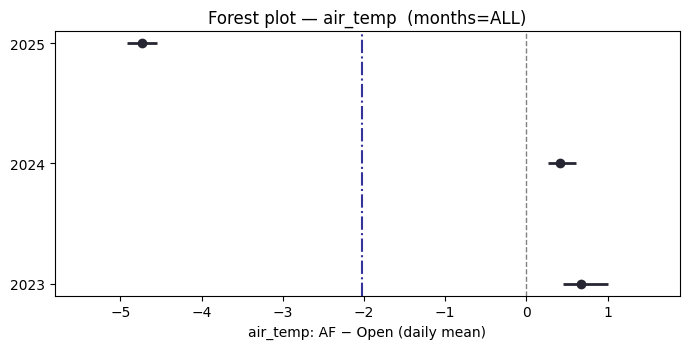

Saved: q1_year_checks_figs/forest_air_temp.png and .pdf


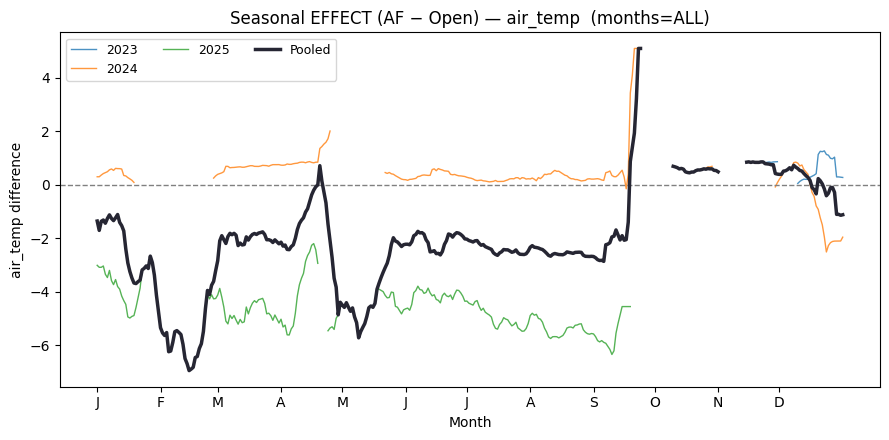

Saved: q1_year_checks_figs/seasonal_effect_years_air_temp.png and .pdf


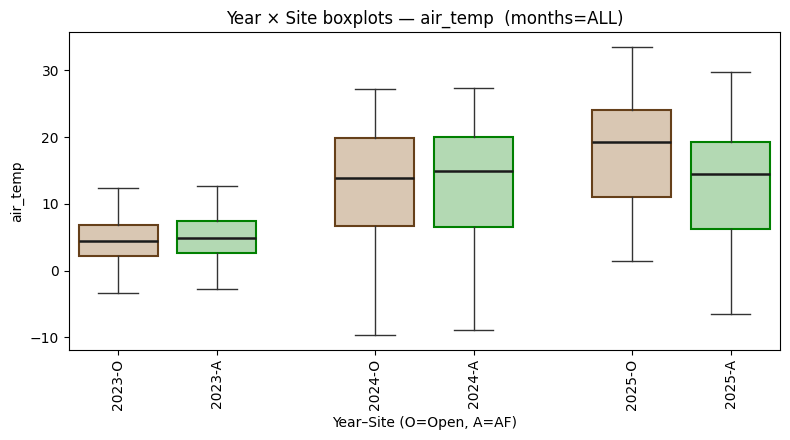

Saved: q1_year_checks_figs/box_year_site_air_temp.png and .pdf

=== rh — using months: ALL ===


/tmp/ipython-input-3101839261.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_year = piv.groupby("year").apply(lambda g: (g["AF"] - g["Open"]).to_numpy())


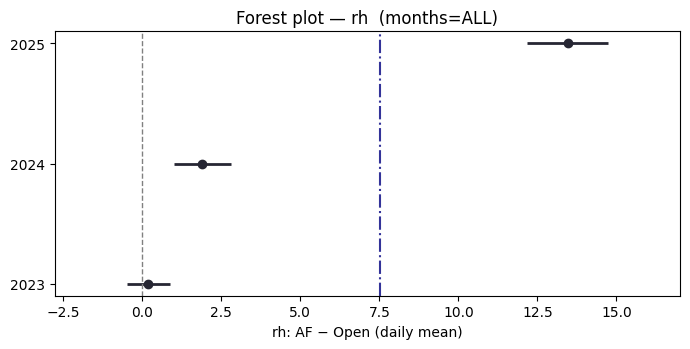

Saved: q1_year_checks_figs/forest_rh.png and .pdf


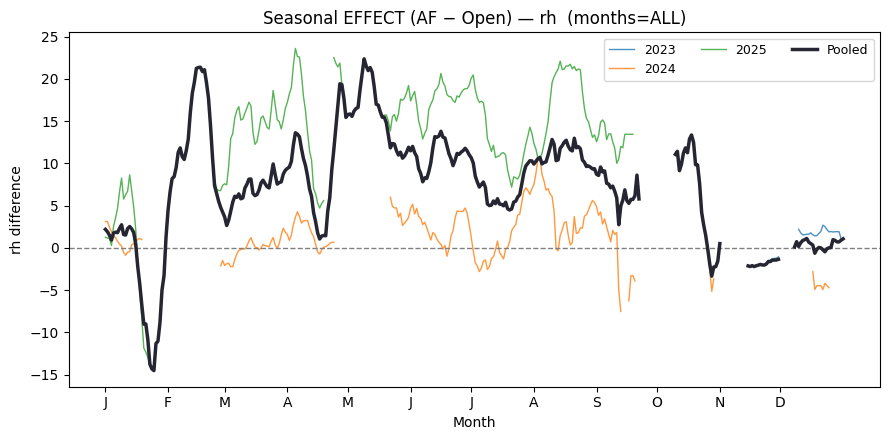

Saved: q1_year_checks_figs/seasonal_effect_years_rh.png and .pdf


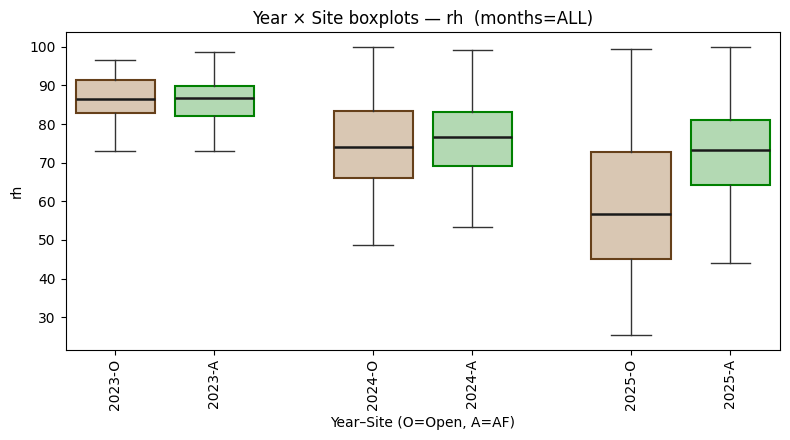

Saved: q1_year_checks_figs/box_year_site_rh.png and .pdf

=== vpd — using months: ALL ===


/tmp/ipython-input-3101839261.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_year = piv.groupby("year").apply(lambda g: (g["AF"] - g["Open"]).to_numpy())


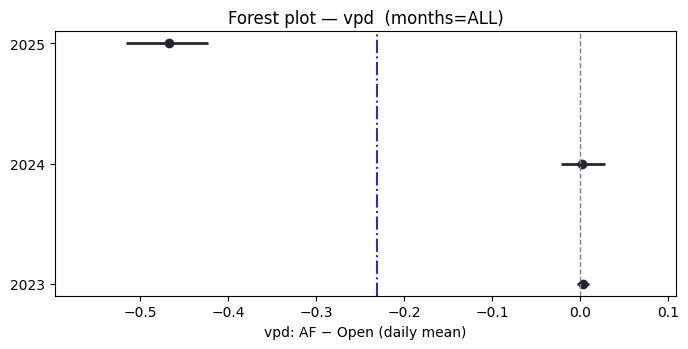

Saved: q1_year_checks_figs/forest_vpd.png and .pdf


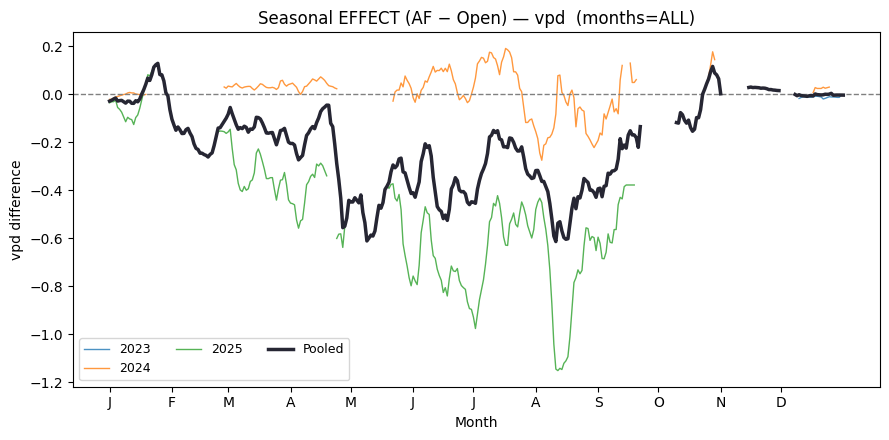

Saved: q1_year_checks_figs/seasonal_effect_years_vpd.png and .pdf


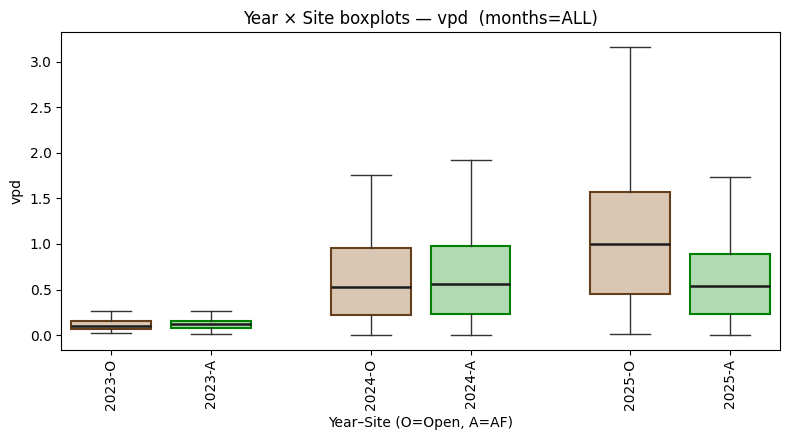

Saved: q1_year_checks_figs/box_year_site_vpd.png and .pdf

=== wind_speed — using months: ALL ===


/tmp/ipython-input-3101839261.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_year = piv.groupby("year").apply(lambda g: (g["AF"] - g["Open"]).to_numpy())


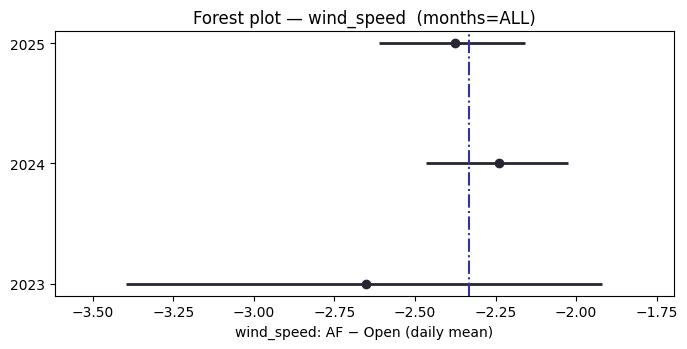

Saved: q1_year_checks_figs/forest_wind_speed.png and .pdf


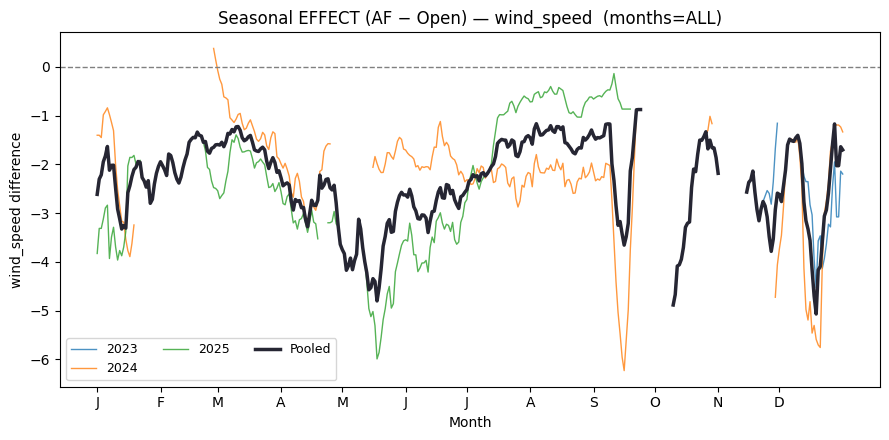

Saved: q1_year_checks_figs/seasonal_effect_years_wind_speed.png and .pdf


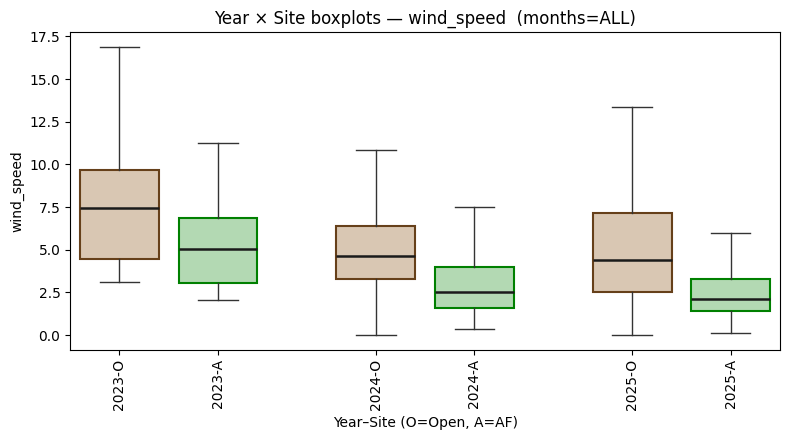

Saved: q1_year_checks_figs/box_year_site_wind_speed.png and .pdf

=== global_radiation — using months: ALL ===


/tmp/ipython-input-3101839261.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_year = piv.groupby("year").apply(lambda g: (g["AF"] - g["Open"]).to_numpy())


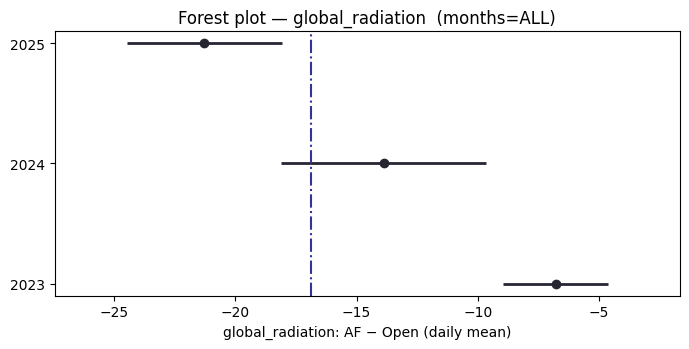

Saved: q1_year_checks_figs/forest_global_radiation.png and .pdf


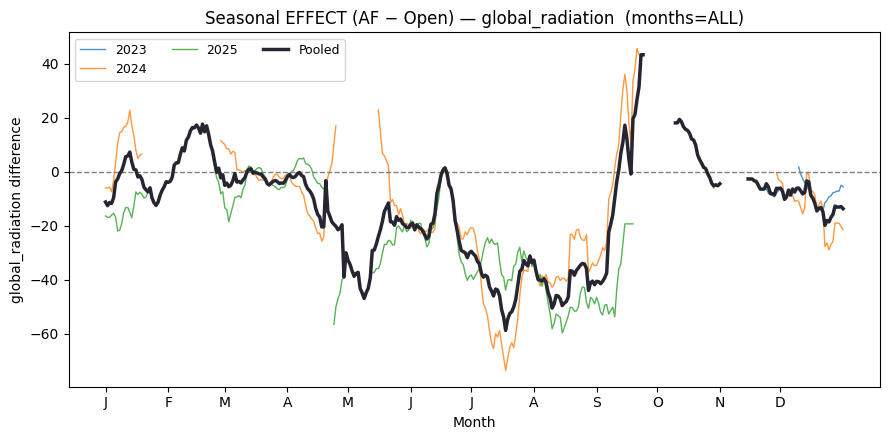

Saved: q1_year_checks_figs/seasonal_effect_years_global_radiation.png and .pdf


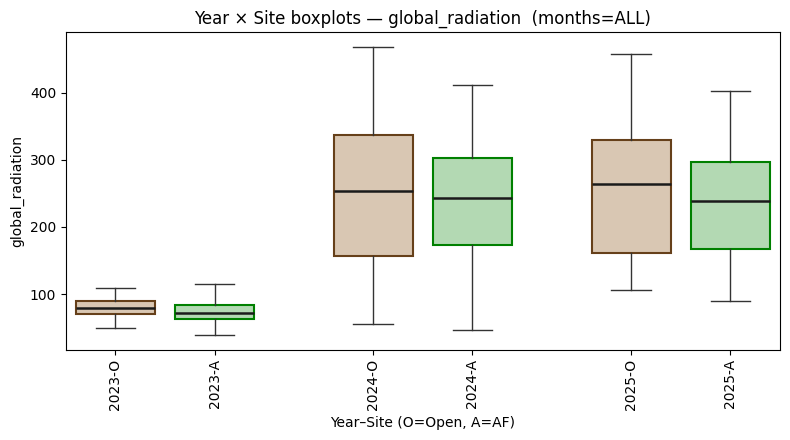

Saved: q1_year_checks_figs/box_year_site_global_radiation.png and .pdf

=== soil_moisture_0 — using months: ALL ===


/tmp/ipython-input-3101839261.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_year = piv.groupby("year").apply(lambda g: (g["AF"] - g["Open"]).to_numpy())


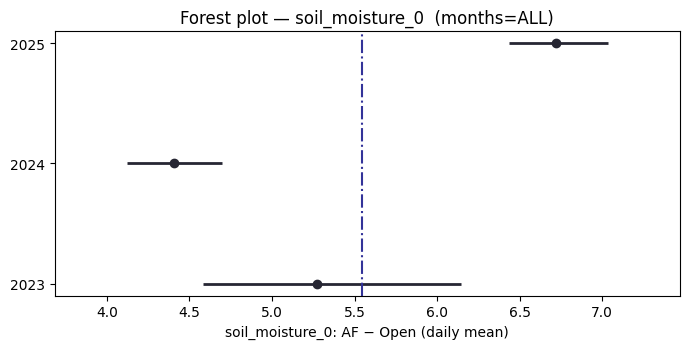

Saved: q1_year_checks_figs/forest_soil_moisture_0.png and .pdf


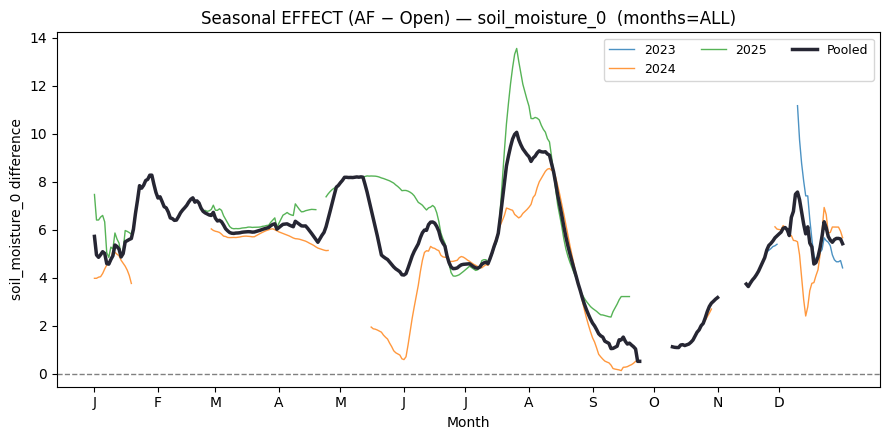

Saved: q1_year_checks_figs/seasonal_effect_years_soil_moisture_0.png and .pdf


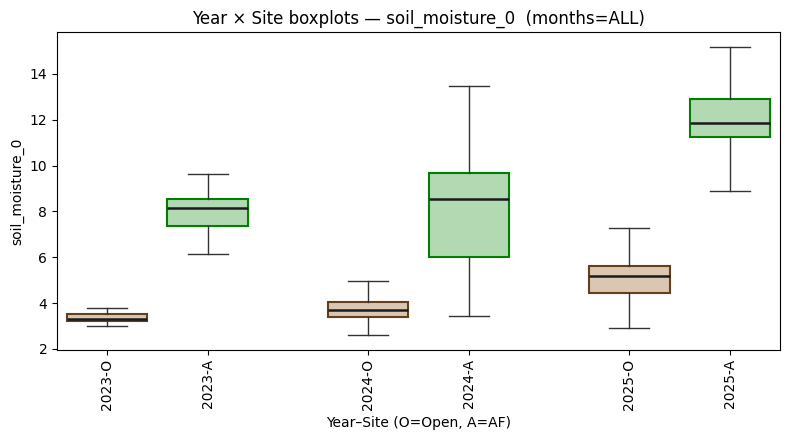

Saved: q1_year_checks_figs/box_year_site_soil_moisture_0.png and .pdf

=== soil_moisture_1 — using months: ALL ===


/tmp/ipython-input-3101839261.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_year = piv.groupby("year").apply(lambda g: (g["AF"] - g["Open"]).to_numpy())


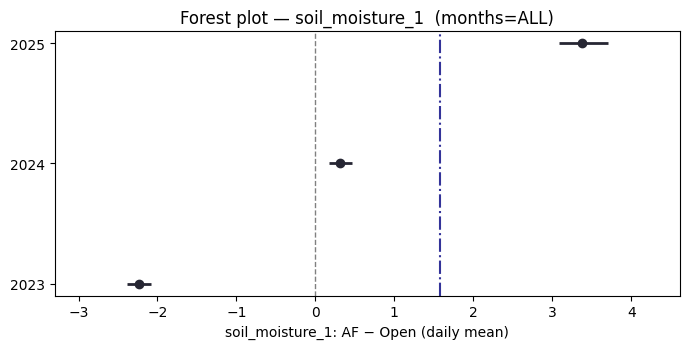

Saved: q1_year_checks_figs/forest_soil_moisture_1.png and .pdf


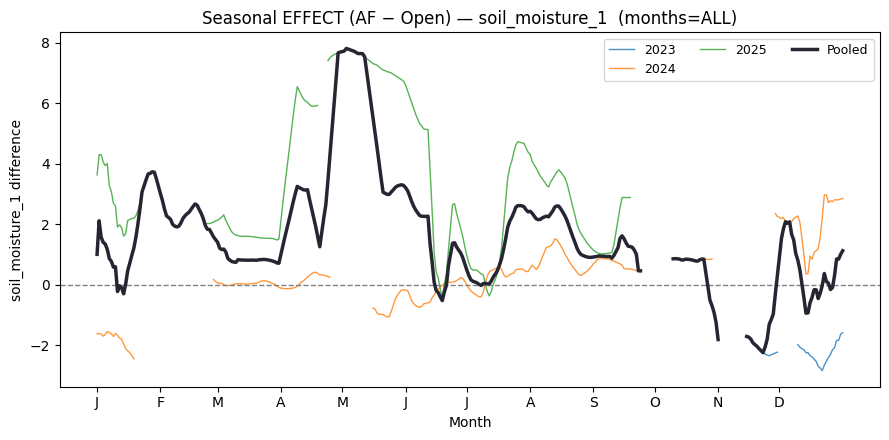

Saved: q1_year_checks_figs/seasonal_effect_years_soil_moisture_1.png and .pdf


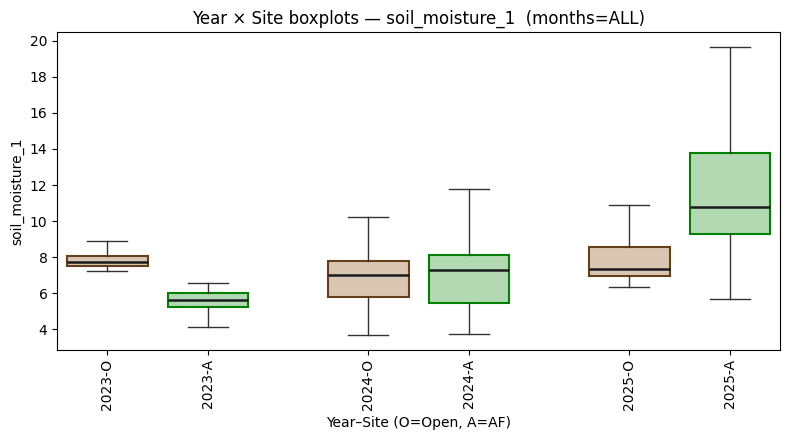

Saved: q1_year_checks_figs/box_year_site_soil_moisture_1.png and .pdf

=== soil_temp_0 — using months: ALL ===


/tmp/ipython-input-3101839261.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_year = piv.groupby("year").apply(lambda g: (g["AF"] - g["Open"]).to_numpy())


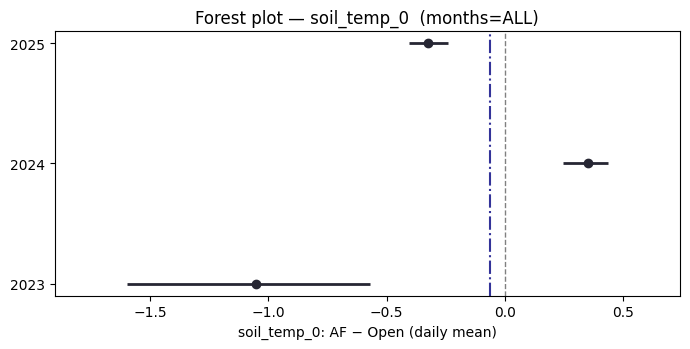

Saved: q1_year_checks_figs/forest_soil_temp_0.png and .pdf


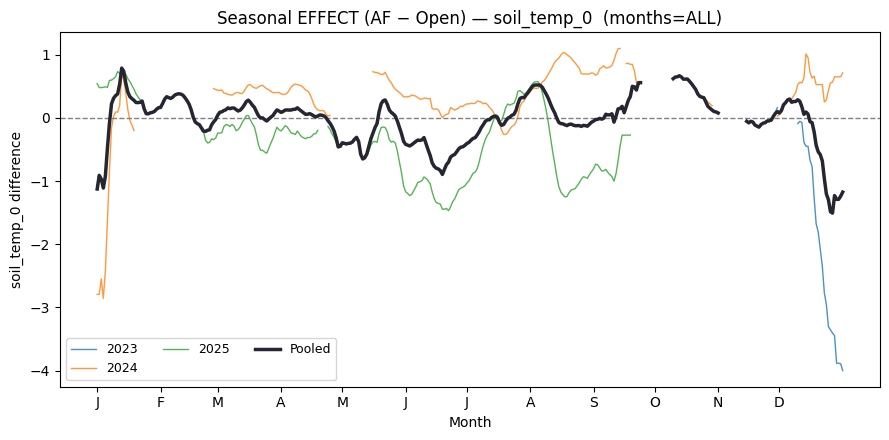

Saved: q1_year_checks_figs/seasonal_effect_years_soil_temp_0.png and .pdf


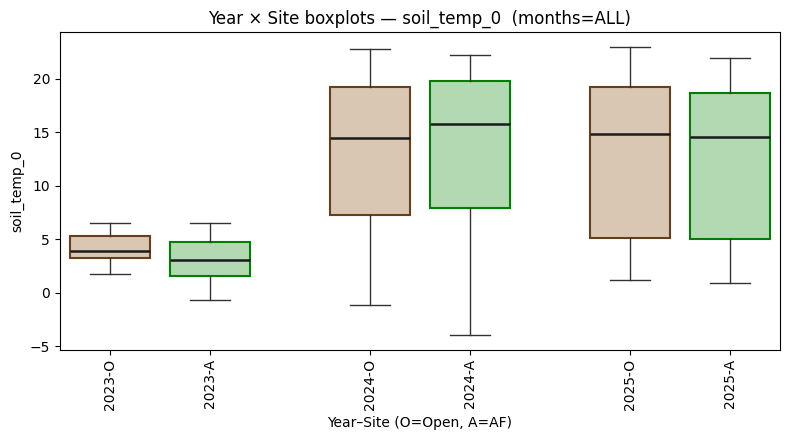

Saved: q1_year_checks_figs/box_year_site_soil_temp_0.png and .pdf

=== soil_temp_1 — using months: ALL ===


/tmp/ipython-input-3101839261.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_year = piv.groupby("year").apply(lambda g: (g["AF"] - g["Open"]).to_numpy())


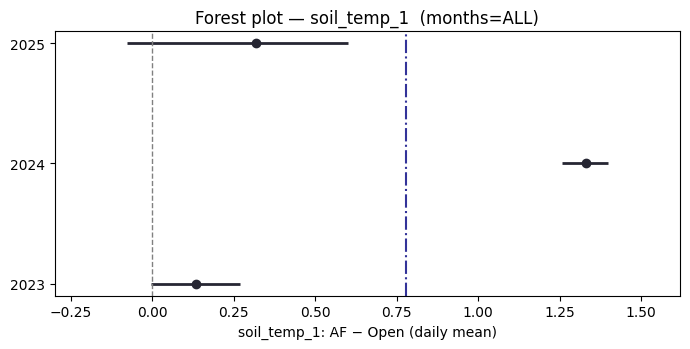

Saved: q1_year_checks_figs/forest_soil_temp_1.png and .pdf


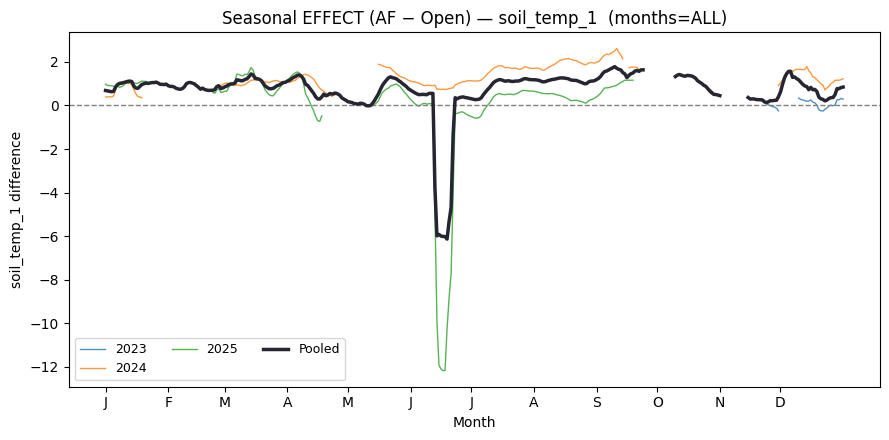

Saved: q1_year_checks_figs/seasonal_effect_years_soil_temp_1.png and .pdf


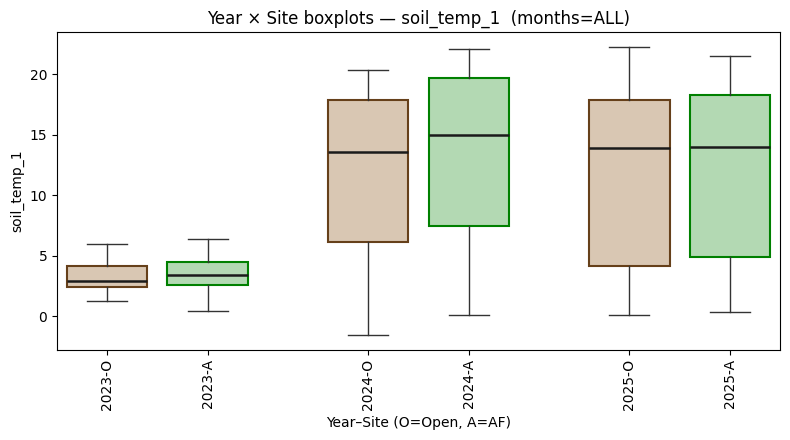

Saved: q1_year_checks_figs/box_year_site_soil_temp_1.png and .pdf

=== soil_moisture — using months: ALL ===


/tmp/ipython-input-3101839261.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_year = piv.groupby("year").apply(lambda g: (g["AF"] - g["Open"]).to_numpy())


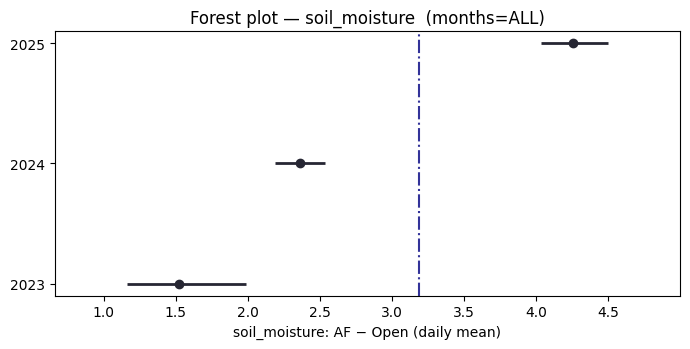

Saved: q1_year_checks_figs/forest_soil_moisture.png and .pdf


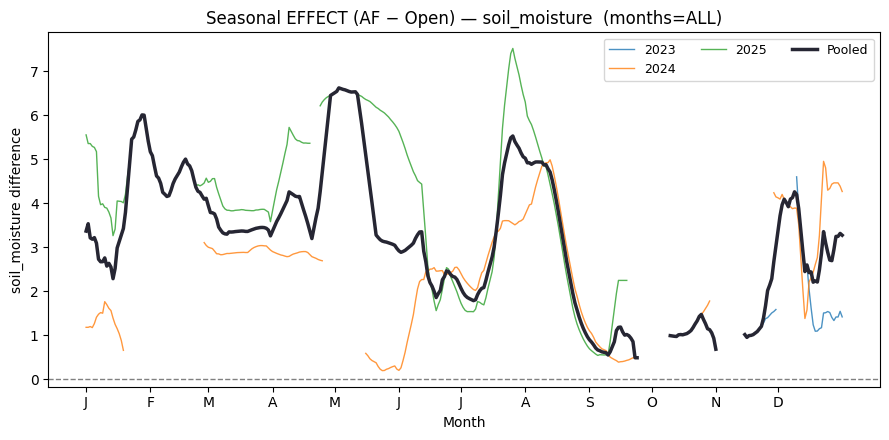

Saved: q1_year_checks_figs/seasonal_effect_years_soil_moisture.png and .pdf


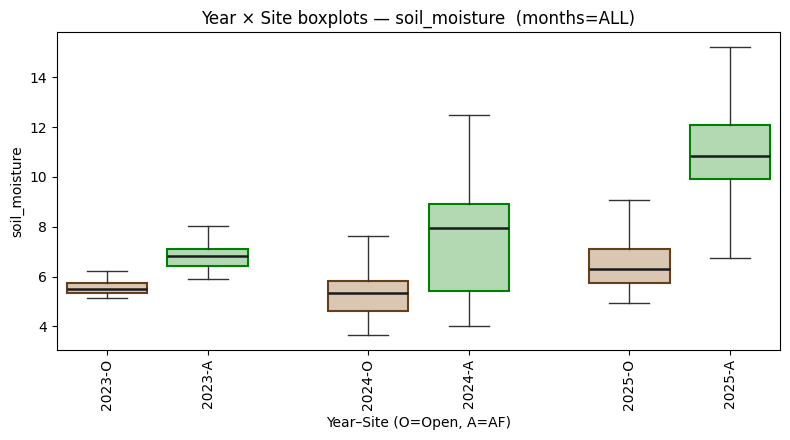

Saved: q1_year_checks_figs/box_year_site_soil_moisture.png and .pdf

=== soil_temp — using months: ALL ===


/tmp/ipython-input-3101839261.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_year = piv.groupby("year").apply(lambda g: (g["AF"] - g["Open"]).to_numpy())


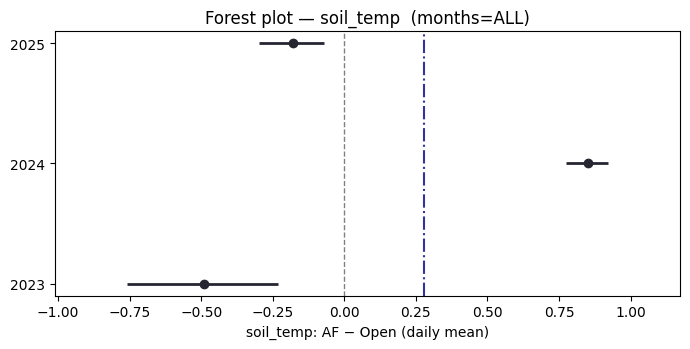

Saved: q1_year_checks_figs/forest_soil_temp.png and .pdf


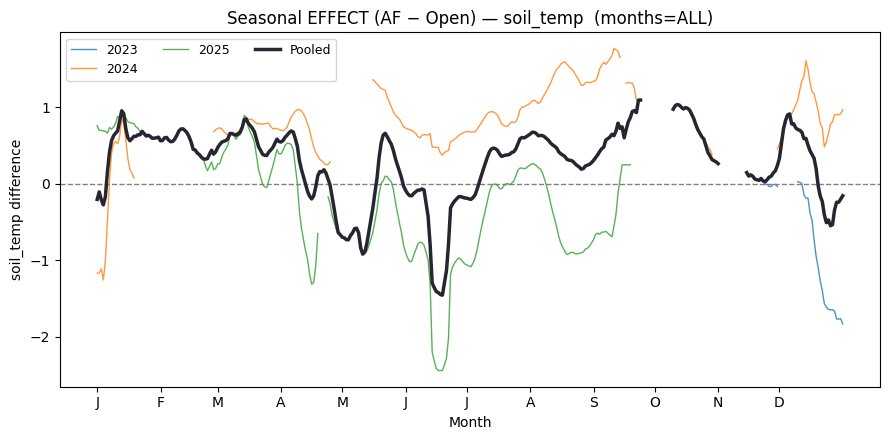

Saved: q1_year_checks_figs/seasonal_effect_years_soil_temp.png and .pdf


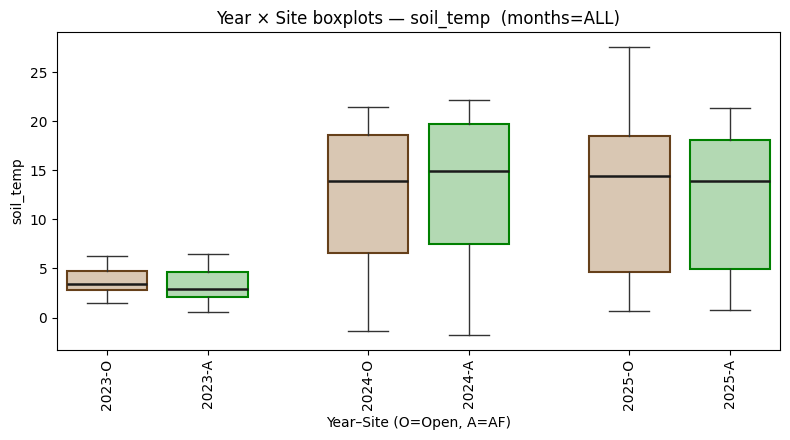

Saved: q1_year_checks_figs/box_year_site_soil_temp.png and .pdf


In [25]:
# === Year-by-year visuals for AF vs Open (overlap months only) ===
# Produces per-variable:
#  1) Forest plot of AF−Open mean differences with 95% CI (per year + pooled)
#  2) Seasonal EFFECT overlays (AF−Open vs DOY) with per-year curves + pooled mean
#  3) Year × Site (Open/AF) boxplots with your color scheme
#
# Requires: `daily`, `NUM_VARS` (mapping var_key -> column in `daily`).
# Uses only rows where _site ∈ {AF, Open}.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Config ---
OUTDIR = "q1_year_checks_figs"
os.makedirs(OUTDIR, exist_ok=True)
DPI = 300
ROLL = globals().get("ROLL_WINDOW_DOY", 9)

# Colors: AF green / Open brown (and light fills)
AF_COLOR      = (0.00, 0.50, 0.00)
OPEN_COLOR    = (0.40, 0.25, 0.10)
AF_LIGHT      = (0.70, 0.85, 0.70)
OPEN_LIGHT    = (0.85, 0.78, 0.70)
EFFECT_COLOR  = (0.15, 0.15, 0.20)

def _rolling_mean(y, w=9):
    s = pd.Series(y)
    return s.rolling(window=w, center=True, min_periods=max(1, w//2)).mean().to_numpy()

def _month_ticks_for_doy():
    # Non-leap template year for consistent DOY tick locations and labels
    base = pd.date_range("2001-01-01", "2001-12-31", freq="MS")
    ticks = [d.dayofyear for d in base]
    labels = ["J","F","M","A","M","J","J","A","S","O","N","D"]
    return ticks, labels

def _overlap_month_subset(d):
    d = d[d["_site"].isin(["AF","Open"])].copy()
    yrs = d["_date"].dt.year.unique()
    if len(yrs) <= 1:
        return d, []
    month_sets = [set(d.loc[d["_date"].dt.year==y, "_date"].dt.month.unique()) for y in yrs]
    common = set.intersection(*month_sets) if month_sets else set()
    if not common:
        return d, []
    sub = d[d["_date"].dt.month.isin(common)].copy()
    return sub, sorted(common)

def _per_year_summaries(d, col):
    # Paired daily AF−Open per year + pooled
    piv = (
        d.pivot_table(index="_date", columns="_site", values=col, aggfunc="mean")
         .dropna(subset=["AF","Open"])
         .assign(year=lambda x: x.index.year)
    )
    if piv.empty:
        return None, None, None
    per_year = piv.groupby("year").apply(lambda g: (g["AF"] - g["Open"]).to_numpy())
    pooled = (piv["AF"] - piv["Open"]).to_numpy()
    years = per_year.index.to_list()
    return per_year, pooled, years

def _ci_boot(vals, B=2000, seed=123, q=(2.5, 97.5)):
    v = np.asarray(vals, float)
    v = v[np.isfinite(v)]
    if v.size == 0:
        return (np.nan, np.nan)
    rng = np.random.default_rng(seed)
    idx = rng.integers(0, v.size, size=(B, v.size))
    m = v[idx].mean(axis=1)
    return tuple(np.percentile(m, list(q)))

def _forest_plot(var_key, col, d, months_used):
    per_year, pooled, years = _per_year_summaries(d, col)
    if per_year is None:
        print(f"[forest] {var_key}: no paired AF/Open days.")
        return
    means  = [np.nanmean(per_year[y]) for y in years]
    ci_lo  = []
    ci_hi  = []
    for y in years:
        lo, hi = _ci_boot(per_year[y], B=2000, seed=123)
        ci_lo.append(lo); ci_hi.append(hi)
    pooled_mean = float(np.nanmean(pooled))
    pmin = np.nanmin(ci_lo + [pooled_mean]); pmax = np.nanmax(ci_hi + [pooled_mean])
    span = pmax - pmin if np.isfinite(pmax - pmin) else 1.0
    xlim = (pmin - 0.15*span, pmax + 0.15*span)

    fig, ax = plt.subplots(figsize=(7, max(3, 1.2*len(years))))
    y_pos = np.arange(len(years))
    ax.hlines(y=y_pos, xmin=ci_lo, xmax=ci_hi, color=EFFECT_COLOR, lw=2)
    ax.plot(means, y_pos, "o", color=EFFECT_COLOR)
    ax.axvline(0, ls="--", lw=1, color=(0.5,0.5,0.5))
    ax.axvline(pooled_mean, ls="-.", lw=1.5, color=(0.2,0.2,0.6))
    ax.set_yticks(y_pos); ax.set_yticklabels([str(y) for y in years])
    ax.set_xlabel(f"{var_key}: AF − Open (daily mean)")
    months_txt = f"months={months_used}" if months_used else "months=ALL"
    ax.set_title(f"Forest plot — {var_key}  ({months_txt})")
    ax.set_xlim(*xlim)
    plt.tight_layout()
    base = os.path.join(OUTDIR, f"forest_{var_key}")
    plt.savefig(base + ".png", dpi=DPI); plt.savefig(base + ".pdf")
    plt.show()
    print("Saved:", base + ".png", "and .pdf")

def _seasonal_effect_overlay(var_key, col, d, months_used):
    # Build per-DOY per-year deltas and overlay curves
    g = d.copy()
    g["_doy"]  = g["_date"].dt.dayofyear
    g["_year"] = g["_date"].dt.year
    gy = g.groupby(["_doy","_year","_site"], dropna=False)[col].mean().reset_index()
    af = gy[gy["_site"]=="AF"].rename(columns={col:"AF"})[["_doy","_year","AF"]]
    op = gy[gy["_site"]=="Open"].rename(columns={col:"Open"})[["_doy","_year","Open"]]
    diff = pd.merge(af, op, on=["_doy","_year"], how="inner")
    if diff.empty:
        print(f"[seasonal-effect] {var_key}: no paired AF/Open per DOY/year.")
        return
    diff["delta"] = diff["AF"] - diff["Open"]

    # pooled across years per DOY
    agg = diff.groupby("_doy")["delta"].mean().reindex(range(1, 367))
    pooled_sm = _rolling_mean(agg.to_numpy(), w=ROLL)

    fig, ax = plt.subplots(figsize=(9,4.5))
    for y, gy in diff.groupby("_year"):
        s = gy.groupby("_doy")["delta"].mean().reindex(range(1, 367)).to_numpy()
        sm = _rolling_mean(s, w=ROLL)
        ax.plot(range(1, 367), sm, lw=1, alpha=0.8, label=str(y))
    # pooled
    ax.plot(range(1, 367), pooled_sm, lw=2.5, color=EFFECT_COLOR, label="Pooled", zorder=10)
    ax.axhline(0, ls="--", lw=1, color=(0.5,0.5,0.5))
    ticks, labels = _month_ticks_for_doy()
    ax.set_xticks(ticks); ax.set_xticklabels(labels)
    months_txt = f"months={months_used}" if months_used else "months=ALL"
    ax.set_title(f"Seasonal EFFECT (AF − Open) — {var_key}  ({months_txt})")
    ax.set_xlabel("Month"); ax.set_ylabel(f"{var_key} difference")
    ax.legend(ncol=3, fontsize=9)
    plt.tight_layout()
    base = os.path.join(OUTDIR, f"seasonal_effect_years_{var_key}")
    plt.savefig(base + ".png", dpi=DPI); plt.savefig(base + ".pdf")
    plt.show()
    print("Saved:", base + ".png", "and .pdf")

def _year_site_boxplots(var_key, col, d, months_used):
    # Build side-by-side boxes per year for Open (brown) and AF (green)
    piv = (
        d.pivot_table(index="_date", columns="_site", values=col, aggfunc="mean")
         .dropna(subset=["AF","Open"])
         .assign(year=lambda x: x.index.year)
    )
    if piv.empty:
        print(f"[box] {var_key}: no paired AF/Open days.")
        return
    years = sorted(piv["year"].unique())
    data = []
    labels = []
    positions = []
    pos = 1
    for y in years:
        g = piv[piv["year"] == y]
        data.append(g["Open"].to_numpy()); labels.append(f"{y}-O"); positions.append(pos); pos += 1
        data.append(g["AF"].to_numpy());   labels.append(f"{y}-A"); positions.append(pos); pos += 1
        pos += 0.6  # gap between years

    fig, ax = plt.subplots(figsize=(max(8, 0.5*len(positions)), 4.5))
    bp = ax.boxplot(data, positions=positions, widths=0.8, showfliers=False, patch_artist=True)
    # color boxes alternating Open/AF
    for i, patch in enumerate(bp['boxes']):
        is_af = (i % 2 == 1)
        patch.set_facecolor(AF_LIGHT if is_af else OPEN_LIGHT)
        patch.set_edgecolor(AF_COLOR if is_af else OPEN_COLOR)
        patch.set_linewidth(1.5)
    for cap in bp['caps']:
        cap.set_color((0.2,0.2,0.2)); cap.set_linewidth(1)
    for whisker in bp['whiskers']:
        whisker.set_color((0.2,0.2,0.2)); whisker.set_linewidth(1)
    for median in bp['medians']:
        median.set_color((0.1,0.1,0.1)); median.set_linewidth(1.8)

    ax.set_xticks(positions); ax.set_xticklabels(labels, rotation=90)
    ax.set_xlabel("Year–Site (O=Open, A=AF)")
    ax.set_ylabel(var_key)
    months_txt = f"months={months_used}" if months_used else "months=ALL"
    ax.set_title(f"Year × Site boxplots — {var_key}  ({months_txt})")
    plt.tight_layout()
    base = os.path.join(OUTDIR, f"box_year_site_{var_key}")
    plt.savefig(base + ".png", dpi=DPI); plt.savefig(base + ".pdf")
    plt.show()
    print("Saved:", base + ".png", "and .pdf")

# ---- Driver: restrict to AF/Open & overlap months, then plot for each variable
d_in = daily.copy()
d_in["_date"] = pd.to_datetime(d_in["_date"])
mask = d_in["_site"].isin(["AF", "Open"])
d_in = d_in[mask].copy()
# ensure numeric
for k, col in NUM_VARS.items():
    if col in d_in.columns:
        d_in[col] = pd.to_numeric(d_in[col], errors="coerce")

d_ov, common_months = _overlap_month_subset(d_in)
months_used_str = ",".join(map(str, common_months)) if common_months else "ALL"

for var_key, col in NUM_VARS.items():
    if col not in d_ov.columns:
        continue
    # Skip obviously circular / diagnostic-only vars if present
    if var_key.lower() in {"wind_dir"}:
        continue
    print(f"\n=== {var_key} — using months: {months_used_str} ===")
    _forest_plot(var_key, col, d_ov, months_used_str)
    _seasonal_effect_overlay(var_key, col, d_ov, months_used_str)
    _year_site_boxplots(var_key, col, d_ov, months_used_str)


Saved: figs_q1/seasonal_air_temp.png, figs_q1/seasonal_air_temp.pdf, figs_q1/seasonal_air_temp.svg


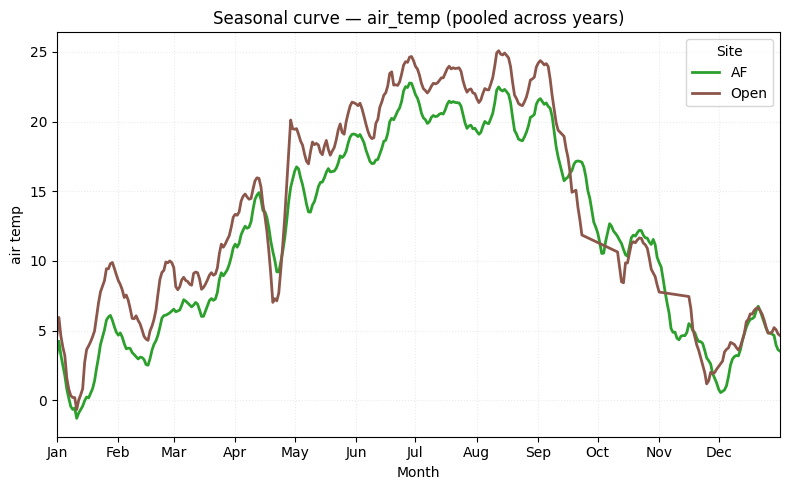

Saved: figs_q1/seasonal_vpd.png, figs_q1/seasonal_vpd.pdf, figs_q1/seasonal_vpd.svg


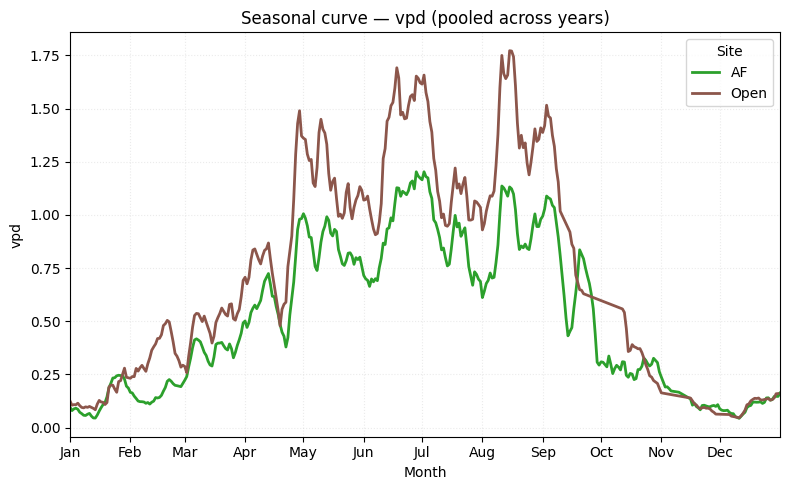

Saved: figs_q1/seasonal_global_radiation.png, figs_q1/seasonal_global_radiation.pdf, figs_q1/seasonal_global_radiation.svg


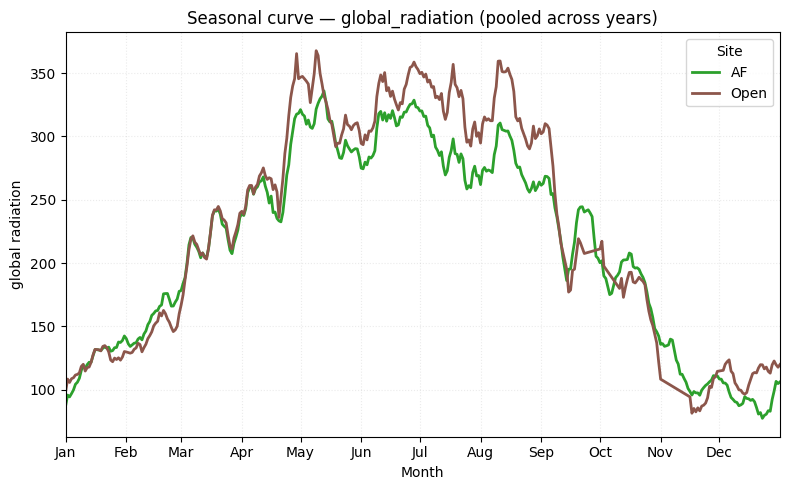

Saved: figs_q1/seasonal_wind_speed.png, figs_q1/seasonal_wind_speed.pdf, figs_q1/seasonal_wind_speed.svg


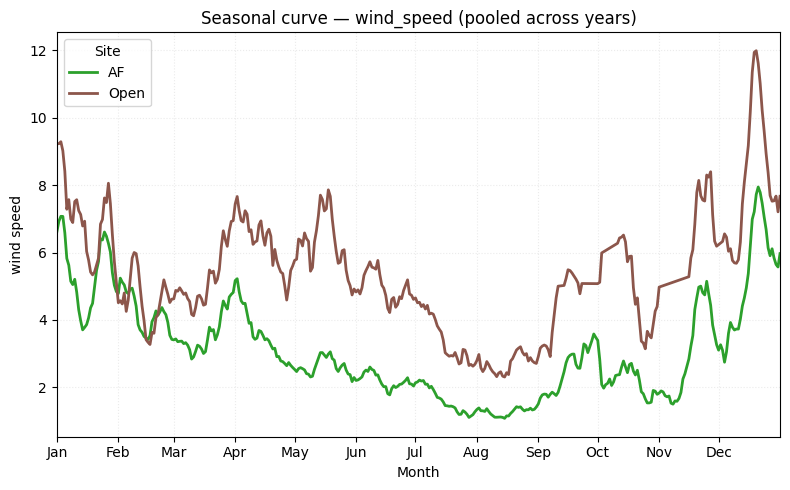

Saved: figs_q1/seasonal_soil_moisture.png, figs_q1/seasonal_soil_moisture.pdf, figs_q1/seasonal_soil_moisture.svg


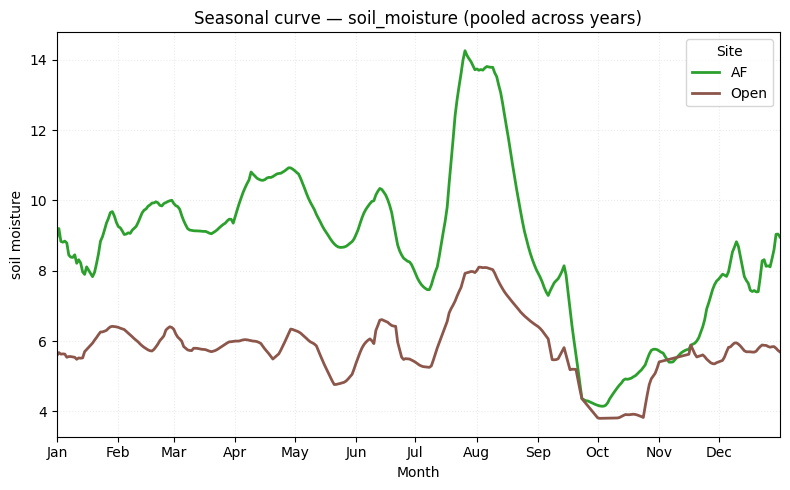

Saved: figs_q1/seasonal_soil_temp.png, figs_q1/seasonal_soil_temp.pdf, figs_q1/seasonal_soil_temp.svg


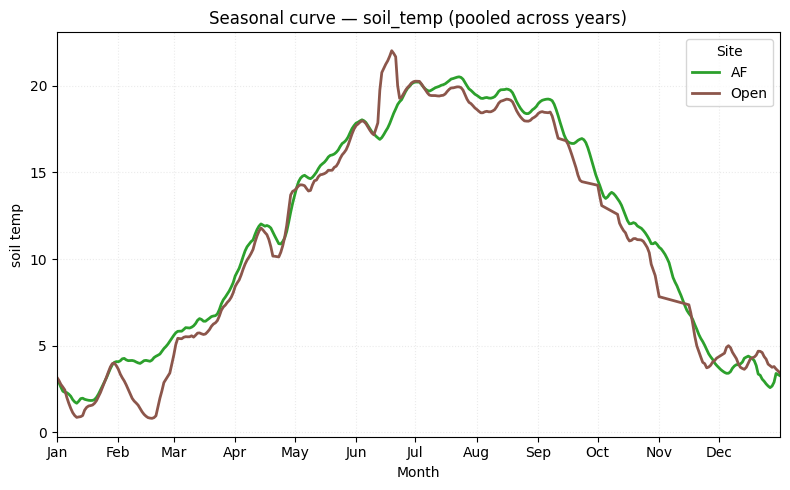

In [9]:
# --- Seasonal plots for ALL variables (AF green, Open brown), high-quality saves ---

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Where to save figures
FIG_DIR = "figs_q1"
os.makedirs(FIG_DIR, exist_ok=True)

# Fixed site colors
SITE_COLORS = {"AF": "#2ca02c",    # green
               "Open": "#8c564b"}  # brown

def _safe_name(s):
    return "".join(ch if ch.isalnum() or ch in "-_." else "_" for ch in str(s))

def export_figure(fig, base_name, dpi=600, fig_dir=FIG_DIR):
    """Save PNG (hi-dpi) + PDF + SVG for crisp slides."""
    base = os.path.join(fig_dir, _safe_name(base_name))
    fig.savefig(base + ".png", dpi=dpi, bbox_inches="tight")
    fig.savefig(base + ".pdf",           bbox_inches="tight")
    fig.savefig(base + ".svg",           bbox_inches="tight")
    print("Saved:", base + ".png,", base + ".pdf,", base + ".svg")

def _month_tick_positions():
    # DOY positions of first day per month (non-leap year reference)
    pos = [pd.Timestamp(2001, m, 1).dayofyear for m in range(1, 13)]
    labs = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
    return pos, labs

def _ensure_soil_composites(daily_df, var_map):
    """Create composite daily columns by averaging the two probes per day/site."""
    # Soil moisture composite
    sm_cols = [var_map.get(k) for k in ("soil_moisture_0","soil_moisture_1")]
    sm_cols = [c for c in sm_cols if c and c in daily_df.columns]
    if sm_cols:
        daily_df["soil_moisture__comp"] = daily_df[sm_cols].mean(axis=1, skipna=True)

    # Soil temperature composite
    st_cols = [var_map.get(k) for k in ("soil_temp_0","soil_temp_1")]
    st_cols = [c for c in st_cols if c and c in daily_df.columns]
    if st_cols:
        daily_df["soil_temp__comp"] = daily_df[st_cols].mean(axis=1, skipna=True)

# Build composites on the current `daily`
_ensure_soil_composites(daily, var_map)

def _column_for_varkey(var_key, var_map, daily_df):
    """Map logical variable name → actual daily column to plot."""
    if var_key == "soil_moisture":
        return "soil_moisture__comp" if "soil_moisture__comp" in daily_df.columns else None
    if var_key == "soil_temp":
        return "soil_temp__comp" if "soil_temp__comp" in daily_df.columns else None
    # otherwise use the mapped column (created when we built `daily`)
    col = var_map.get(var_key)
    return col if (col in daily_df.columns) else None

def plot_seasonal_allvars(daily_df, var_keys, window=ROLL_WINDOW_DOY):
    # Focus on AF/Open if present
    has_afopen = daily_df["_site"].isin(["AF","Open"]).any()
    dfp = daily_df if not has_afopen else daily_df[daily_df["_site"].isin(["AF","Open"])].copy()
    if dfp.empty:
        print("No AF/Open data to plot.");
        return

    # Day-of-year for pooling across years
    dfp["_doy"]  = pd.to_datetime(dfp["_date"]).dt.dayofyear

    xticks, xlabels = _month_tick_positions()

    for vk in var_keys:
        col = _column_for_varkey(vk, var_map, dfp)
        if not col:
            print(f"Skip {vk}: column not found in 'daily'.")
            continue

        dsub = dfp.dropna(subset=[col]).copy()
        if dsub.empty:
            print(f"Skip {vk}: no data.")
            continue

        # Mean per DOY × site (pooled across years)
        g = dsub.groupby(["_doy","_site"], dropna=False)[col].mean().reset_index()
        # Smooth per site
        g["smooth"] = g.groupby("_site")[col].transform(lambda s: rolling_smooth(s, window=max(3, window)))

        fig = plt.figure(figsize=(8,5))
        any_site = False
        for site in ["AF","Open"]:
            s = g[g["_site"] == site].sort_values("_doy")
            if s.empty:
                continue
            any_site = True
            plt.plot(s["_doy"], s["smooth"], label=site, linewidth=2, color=SITE_COLORS.get(site, None))

        if not any_site:
            plt.close(fig); print(f"Skip {vk}: no AF/Open data."); continue

        plt.xlim(1, 366)
        plt.xticks(xticks, xlabels, rotation=0)
        plt.xlabel("Month")
        plt.ylabel(vk.replace("_"," "))
        plt.title(f"Seasonal curve — {vk} (pooled across years)")
        plt.legend(title="Site")
        plt.grid(alpha=0.25, linestyle=":")

        fname = f"seasonal_{vk}"
        plt.tight_layout()
        export_figure(fig, fname)
        plt.show()

# --- Choose which variables to render ---
# These should exist in your var_map (mapped to daily columns), plus composites we just made.
PLOT_KEYS = [
    "air_temp",
    "vpd",
    "global_radiation",
    "wind_speed",
    "soil_moisture",   # <- composite of 0/1
    "soil_temp"        # <- composite of 0/1
]

plot_seasonal_allvars(daily, PLOT_KEYS, window=ROLL_WINDOW_DOY)


In [10]:
# @title Paired AF–Open daily differences with permutation p-values and BH–FDR

# Aliases from earlier
ALIASES = {
    "soil_moisture": ["soil_moisture_0", "soil_moisture_1"],
    "soil_temp":     ["soil_temp_0",     "soil_temp_1"],
}

def _resolve_columns_for_stats(var_key, var_map, daily_df):
    """
    Prefer direct composite mapping (e.g., 'soil_moisture' -> 'soil_moisture__pref').
    If absent, expand to probe-depth keys via ALIASES.
    Returns list of tuples: (label_key, column_name)
      - label_key is what will appear in the summary 'variable' column.
    """
    direct = var_map.get(var_key)
    if direct and direct in daily_df.columns:
        return [(var_key, direct)]  # single composite

    pairs = []
    for k in ALIASES.get(var_key, []):
        col = var_map.get(k)
        if col and col in daily_df.columns:
            pairs.append((k, col))  # e.g., ('soil_moisture_0', 'ground_humidity_0__pref')
    return pairs

rng = np.random.default_rng(RANDOM_SEED)

summary_rows = []
pvals = {}

# Variables to test for Q1 (wind_dir excluded by design)
VAR_KEYS = ["air_temp", "rh", "vpd", "wind_speed", "global_radiation", "soil_moisture", "soil_temp"]

for var_key in VAR_KEYS:
    for label_key, col in _resolve_columns_for_stats(var_key, var_map, daily):
        # Need both AF and Open present on the same dates
        pivot = daily.pivot_table(index="_date", columns="_site", values=col, aggfunc="mean")
        if "AF" not in pivot.columns or "Open" not in pivot.columns:
            continue

        diffs = (pivot["AF"] - pivot["Open"]).dropna().values
        n = diffs.size

        if n < 5:
            mean_diff = np.nan; ci_lo = np.nan; ci_hi = np.nan; p = np.nan
        else:
            mean_diff = float(np.mean(diffs))
            # bootstrap CI for mean difference
            idx = rng.integers(0, n, size=(BOOTSTRAP_B, n))
            boot_means = diffs[idx].mean(axis=1)
            ci_lo, ci_hi = np.percentile(boot_means, [2.5, 97.5])
            # paired permutation p-value
            p = paired_permutation_pvalue(diffs, reps=PERM_REPS, seed=RANDOM_SEED)

        pvals[label_key] = p
        summary_rows.append({
            "variable": label_key,          # e.g., 'soil_moisture' or 'soil_moisture_0'
            "source_key": var_key,          # parent family for grouping if desired
            "column": col,                  # daily column used
            "contrast": "AF - Open",
            "mean_diff": mean_diff,
            "ci95_lo": ci_lo,
            "ci95_hi": ci_hi,
            "n_days": int(n),
            "p_perm": p
        })

# Multiple testing correction (BH–FDR) across all tested rows
qvals = benjamini_hochberg(pvals)
for r in summary_rows:
    r["q_fdr"] = qvals.get(r["variable"], np.nan)

summary = (
    pd.DataFrame(summary_rows)
      .sort_values(["source_key", "variable"])
      .reset_index(drop=True)
)

display(summary)

OUT_SUMMARY = "q1_af_vs_open_summary.csv"
summary.to_csv(OUT_SUMMARY, index=False)
print("Saved:", OUT_SUMMARY)


,variable,source_key,column,contrast,mean_diff,ci95_lo,ci95_hi,n_days,p_perm,q_fdr
0,air_temp,air_temp,temperature__pref,AF - Open,-2.029711,-2.287597,-1.767052,519,0.0005,0.0005
1,global_radiation,global_radiation,global_radiation__pref,AF - Open,-16.872273,-19.235775,-14.351387,529,0.0005,0.0005
2,rh,rh,humidity__pref,AF - Open,7.509897,6.564221,8.403289,489,0.0005,0.0005
3,soil_moisture,soil_moisture,soil_moisture__pref,AF - Open,3.189843,3.018549,3.349072,527,0.0005,0.0005
4,soil_temp,soil_temp,soil_temp__pref,AF - Open,0.277255,0.191596,0.358727,524,0.0005,0.0005
5,vpd,vpd,_vpd_calc,AF - Open,-0.230405,-0.265335,-0.197449,488,0.0005,0.0005
6,wind_speed,wind_speed,wind_speed_mean__pref,AF - Open,-2.331041,-2.491336,-2.184918,529,0.0005,0.0005


Saved: q1_af_vs_open_summary.csv


In [18]:
# @title Useful plots for Q1 (seasonal ribbons, seasonal effect, AF~Open scatter, ECDFs, month boxplots)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8,5)

# --- Safety: rebuild NUM_VARS and daily if this cell is run first ---
try:
    NUM_VARS
except NameError:
    # requires var_map from the mapping cell
    NUM_VARS = {k: v for k, v in var_map.items() if v is not None and k != "wind_dir"}

if 'daily' not in globals():
    # requires df with _ts, _site, and the NUM_VARS columns
    mask_known = df["_site"].astype(str).isin(["AF", "Open"])
    df_use = df[mask_known].copy() if mask_known.sum() >= 100 else df.copy()
    for k, col in NUM_VARS.items():
        df_use[col] = pd.to_numeric(df_use[col], errors="coerce")
    df_use["_date"] = df_use["_ts"].dt.floor("D")
    daily = df_use.groupby(["_date", "_site"], dropna=False).agg(
        {col: "mean" for col in NUM_VARS.values()}
    ).reset_index()

# Aliases: expand family → depth-specific keys if composite isn't directly mapped
ALIASES = {
    "soil_moisture": ["soil_moisture_0", "soil_moisture_1"],
    "soil_temp":     ["soil_temp_0",     "soil_temp_1"],
}

def _resolve_keys(var_key, num_vars):
    if var_key in num_vars:
        return [var_key]
    return [k for k in ALIASES.get(var_key, []) if k in num_vars]

def _doy_year(df_like):
    d = df_like.copy()
    d["_doy"] = pd.to_datetime(d["_date"]).dt.dayofyear
    d["_year"] = pd.to_datetime(d["_date"]).dt.year
    return d

# ---------- 1) Seasonal ribbons (mean ± CI across years) per site ----------
def plot_seasonal_ribbon(daily_df, var_key, window=ROLL_WINDOW_DOY, ci=(2.5,97.5)):
    keys = _resolve_keys(var_key, NUM_VARS)
    if not keys:
        print(f"Skip {var_key}: not detected.")
        return

    for k in keys:
        col = NUM_VARS[k]
        dsub = daily_df.dropna(subset=[col]).copy()
        if dsub.empty:
            print(f"Skip {k}: no data.")
            continue

        mask = dsub["_site"].isin(["AF","Open"])
        if mask.any():
            dsub = dsub[mask].copy()

        dsub = _doy_year(dsub)
        g = dsub.groupby(["_doy","_year","_site"], dropna=False)[col].mean().reset_index()

        plt.figure()
        any_site=False
        for site in ["AF","Open"]:
            s = g[g["_site"]==site]
            if s.empty:
                continue
            any_site=True

            agg = s.groupby("_doy")[col].agg(["mean","count"])
            nyears = s["_year"].nunique()
            if nyears >= 5:
                lo = s.groupby("_doy")[col].quantile(ci[0]/100.0)
                hi = s.groupby("_doy")[col].quantile(ci[1]/100.0)
            else:
                std = s.groupby("_doy")[col].std().fillna(0.0)
                n = agg["count"].clip(lower=1)
                half = 1.96 * (std / np.sqrt(n))
                lo = agg["mean"] - half
                hi = agg["mean"] + half

            mean_sm = pd.Series(agg["mean"]).rolling(
                window=window, center=True, min_periods=max(1,window//2)
            ).mean()

            x = agg.index.values
            plt.plot(x, mean_sm.values, label=f"{site}")
            plt.fill_between(x, lo.reindex(x).values, hi.reindex(x).values, alpha=0.2)

        if not any_site:
            plt.close()
            print(f"Skip {k}: no AF/Open data.")
            continue

        plt.xlabel("Day of Year")
        plt.ylabel(k)
        plt.title(f"Seasonal ribbon — {k} (mean ± CI across years)")
        plt.legend()
        fname = f"seasonal_ribbon_{k}.png"
        plt.tight_layout(); plt.savefig(fname, dpi=150); plt.show()
        print("Saved:", fname)

# ---------- 2) Seasonal EFFECT curve (AF − Open) with CI across years ----------
def plot_seasonal_effect(daily_df, var_key, window=ROLL_WINDOW_DOY, ci=(2.5,97.5)):
    keys = _resolve_keys(var_key, NUM_VARS)
    if not keys:
        print(f"Skip {var_key}: not detected.")
        return

    for k in keys:
        col = NUM_VARS[k]
        dsub = daily_df.dropna(subset=[col]).copy()
        if dsub.empty:
            print(f"Skip {k}: no data.")
            continue

        dsub = dsub[dsub["_site"].isin(["AF","Open"])].copy()
        if dsub.empty:
            print(f"Skip {k}: no AF/Open data.")
            continue

        dsub = _doy_year(dsub)
        g = dsub.groupby(["_doy","_year","_site"], dropna=False)[col].mean().reset_index()
        af = g[g["_site"]=="AF"].rename(columns={col:"AF"})
        op = g[g["_site"]=="Open"].rename(columns={col:"Open"})
        diff = pd.merge(af[["_doy","_year","AF"]],
                        op[["_doy","_year","Open"]],
                        on=["_doy","_year"], how="inner")
        if diff.empty:
            print(f"Skip {k}: no paired AF-Open per DOY/year.")
            continue

        diff["delta"] = diff["AF"] - diff["Open"]
        agg = diff.groupby("_doy")["delta"].agg(["mean","count"])
        nyears = diff["_year"].nunique()
        if nyears >= 5:
            lo = diff.groupby("_doy")["delta"].quantile(ci[0]/100.0)
            hi = diff.groupby("_doy")["delta"].quantile(ci[1]/100.0)
        else:
            std = diff.groupby("_doy")["delta"].std().fillna(0.0)
            n = agg["count"].clip(lower=1)
            half = 1.96 * (std / np.sqrt(n))
            lo = agg["mean"] - half
            hi = agg["mean"] + half

        mean_sm = pd.Series(agg["mean"]).rolling(
            window=window, center=True, min_periods=max(1,window//2)
        ).mean()
        x = agg.index.values

        plt.figure()
        plt.axhline(0, linestyle="--", linewidth=1)
        plt.plot(x, mean_sm.values, label="AF - Open")
        plt.fill_between(x, lo.reindex(x).values, hi.reindex(x).values, alpha=0.2)
        plt.xlabel("Day of Year")
        plt.ylabel(f"{k} difference")
        plt.title(f"Seasonal EFFECT (AF − Open) — {k}")
        plt.legend()
        fname = f"seasonal_effect_{k}.png"
        plt.tight_layout(); plt.savefig(fname, dpi=150); plt.show()
        print("Saved:", fname)

# ---------- 3) AF vs Open scatter with 1:1 line, slope & r ----------
def plot_scatter_af_open(daily_df, var_key, max_points=5000):
    keys = _resolve_keys(var_key, NUM_VARS)
    if not keys:
        print(f"Skip {var_key}: not detected.")
        return

    for k in keys:
        col = NUM_VARS[k]
        pivot = daily_df.pivot_table(index="_date", columns="_site", values=col, aggfunc="mean")
        if not {"AF","Open"}.issubset(pivot.columns):
            print(f"Skip {k}: need both AF and Open.")
            continue
        p = pivot.dropna()
        if p.empty:
            print(f"Skip {k}: no paired days.")
            continue
        if len(p) > max_points:
            p = p.sample(max_points, random_state=123)

        af = p["AF"].values
        op = p["Open"].values

        mn = float(np.nanmin([af.min(), op.min()]))
        mx = float(np.nanmax([af.max(), op.max()]))

        plt.figure()
        plt.scatter(op, af, s=10, alpha=0.5)
        plt.plot([mn, mx], [mn, mx], linestyle="--")  # identity

        if len(p) >= 2:
            slope, intercept = np.polyfit(op, af, 1)
            r = np.corrcoef(op, af)[0,1]
            txt = f"n={len(p)}  slope={slope:.2f}  r={r:.2f}"
        else:
            txt = f"n={len(p)}"
        plt.text(mn + 0.02*(mx-mn), mx - 0.08*(mx-mn), txt)

        plt.xlabel("Open")
        plt.ylabel("AF")
        plt.title(f"Paired daily values — {k}")
        fname = f"scatter_AF_vs_Open_{k}.png"
        plt.tight_layout(); plt.savefig(fname, dpi=150); plt.show()
        print("Saved:", fname)

# ---------- 4) ECDFs (empirical CDF) of daily values per site ----------
def plot_ecdf(daily_df, var_key):
    keys = _resolve_keys(var_key, NUM_VARS)
    if not keys:
        print(f"Skip {var_key}: not detected.")
        return

    for k in keys:
        col = NUM_VARS[k]
        dsub = daily_df.dropna(subset=[col]).copy()
        if dsub.empty:
            print(f"Skip {k}: no data.")
            continue

        mask = dsub["_site"].isin(["AF","Open"])
        if mask.any():
            dsub = dsub[mask].copy()

        plt.figure()
        any_site=False
        for site in ["AF","Open"]:
            vals = pd.to_numeric(dsub.loc[dsub["_site"]==site, col], errors="coerce").dropna().values
            if vals.size == 0:
                continue
            any_site=True
            v = np.sort(vals)
            y = np.arange(1, v.size+1) / v.size
            plt.plot(v, y, label=site)

        if not any_site:
            plt.close(); print(f"Skip {k}: no AF/Open data."); continue

        plt.xlabel(k)
        plt.ylabel("ECDF")
        plt.title(f"Empirical CDF — {k} (daily means)")
        plt.legend()
        fname = f"ecdf_{k}.png"
        plt.tight_layout(); plt.savefig(fname, dpi=150); plt.show()
        print("Saved:", fname)

# ---------- 5) Month-wise boxplots per site (AF=light green, Open=light brown; robust coloring) ----------
import matplotlib.patches as mpatches

AF_FILL   = "#CDE9B4"  # light green
AF_EDGE   = "#2e7d32"  # dark green
OPEN_FILL = "#E3C8A8"  # light brown/tan
OPEN_EDGE = "#6d4c41"  # dark brown

def plot_month_boxplots(daily_df, var_key):
    keys = _resolve_keys(var_key, NUM_VARS)
    if not keys:
        print(f"Skip {var_key}: not detected.")
        return

    for k in keys:
        col = NUM_VARS[k]
        dsub = daily_df.dropna(subset=[col]).copy()
        if dsub.empty:
            print(f"Skip {k}: no data.")
            continue

        # Focus on AF/Open if present
        mask = dsub["_site"].isin(["AF", "Open"])
        if mask.any():
            dsub = dsub[mask].copy()

        dsub["_month"] = pd.to_datetime(dsub["_date"]).dt.month

        # Build monthly series for each site
        data_open, data_af = [], []
        pos_open, pos_af, labels = [], [], []
        # positions: Open at 3*m-2, AF at 3*m-1; leaves a small gap each month
        for m in range(1, 13):
            vals_open = pd.to_numeric(
                dsub.loc[(dsub["_month"] == m) & (dsub["_site"] == "Open"), col],
                errors="coerce"
            ).dropna().values
            vals_af = pd.to_numeric(
                dsub.loc[(dsub["_month"] == m) & (dsub["_site"] == "AF"), col],
                errors="coerce"
            ).dropna().values
            data_open.append(vals_open)
            data_af.append(vals_af)
            pos_open.append(3*m - 2)
            pos_af.append(3*m - 1)
            labels.extend([f"{m}-O", f"{m}-A"])

        if not any(len(v) for v in data_open + data_af):
            print(f"Skip {k}: no values per month.")
            continue

        plt.figure(figsize=(14, 5))

        # Draw Open (brown)
        bp_open = plt.boxplot(
            data_open,
            positions=pos_open,
            widths=0.8,
            showfliers=False,
            patch_artist=True,
            boxprops=dict(facecolor=OPEN_FILL, edgecolor=OPEN_EDGE),
            medianprops=dict(color=OPEN_EDGE),
            whiskerprops=dict(color=OPEN_EDGE),
            capprops=dict(color=OPEN_EDGE),
        )

        # Draw AF (green)
        bp_af = plt.boxplot(
            data_af,
            positions=pos_af,
            widths=0.8,
            showfliers=False,
            patch_artist=True,
            boxprops=dict(facecolor=AF_FILL, edgecolor=AF_EDGE),
            medianprops=dict(color=AF_EDGE),
            whiskerprops=dict(color=AF_EDGE),
            capprops=dict(color=AF_EDGE),
        )

        # X ticks
        xticks = [v for pair in zip(pos_open, pos_af) for v in pair]
        plt.xticks(xticks, labels, rotation=90)
        plt.xlabel("Month–Site (O=Open, A=AF)")
        plt.ylabel(k)
        plt.title(f"Monthly distribution (daily means) — {k}")

        # Legend
        legend_handles = [
            mpatches.Patch(facecolor=OPEN_FILL, edgecolor=OPEN_EDGE, label="Open"),
            mpatches.Patch(facecolor=AF_FILL,   edgecolor=AF_EDGE,   label="AF"),
        ]
        plt.legend(handles=legend_handles, loc="best", frameon=False)

        # Save hi-res PNG + vector PDF for slide-friendly quality
        fname_png = f"box_month_{k}.png"
        fname_pdf = f"box_month_{k}.pdf"
        plt.tight_layout()
        plt.savefig(fname_png, dpi=300)
        plt.savefig(fname_pdf)
        plt.show()
        print("Saved:", fname_png, "and", fname_pdf)


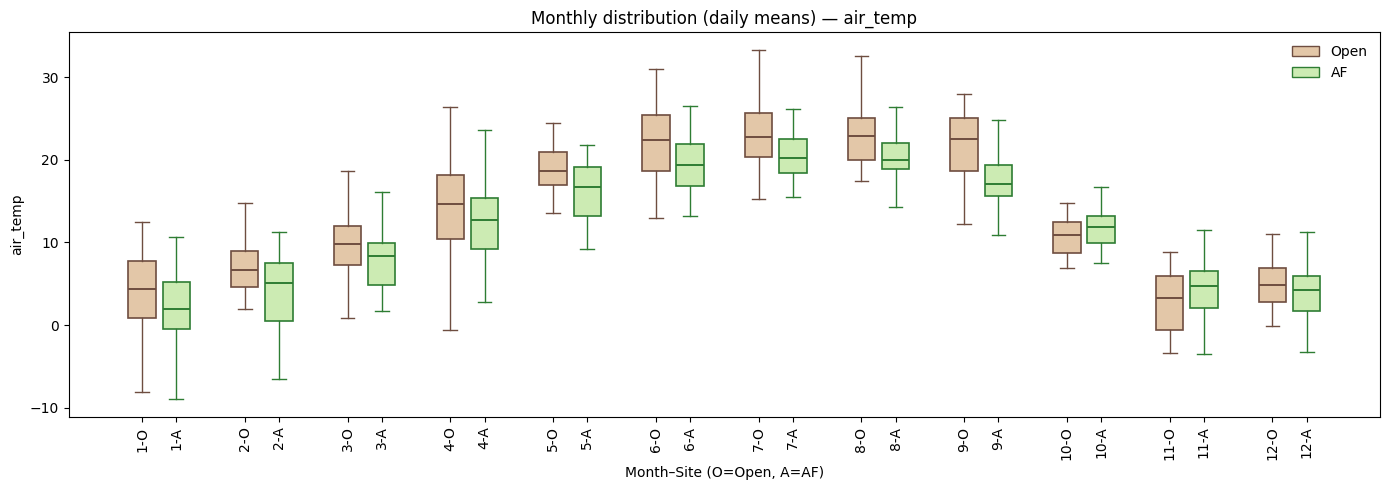

Saved: fig_q1/q1_box_month_air_temp.png and fig_q1/q1_box_month_air_temp.pdf


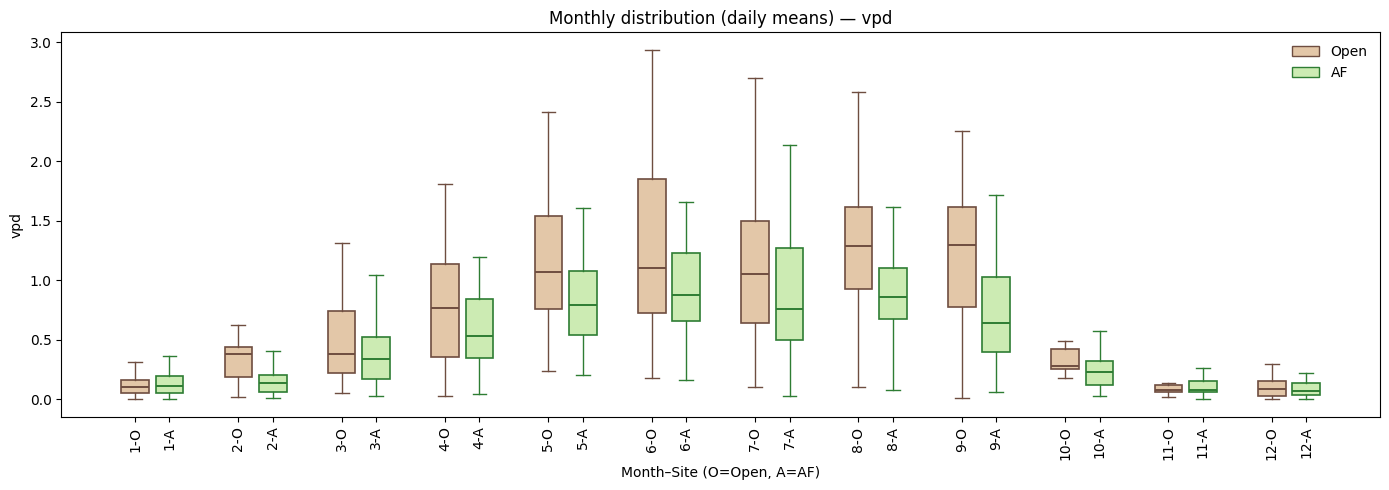

Saved: fig_q1/q1_box_month_vpd.png and fig_q1/q1_box_month_vpd.pdf


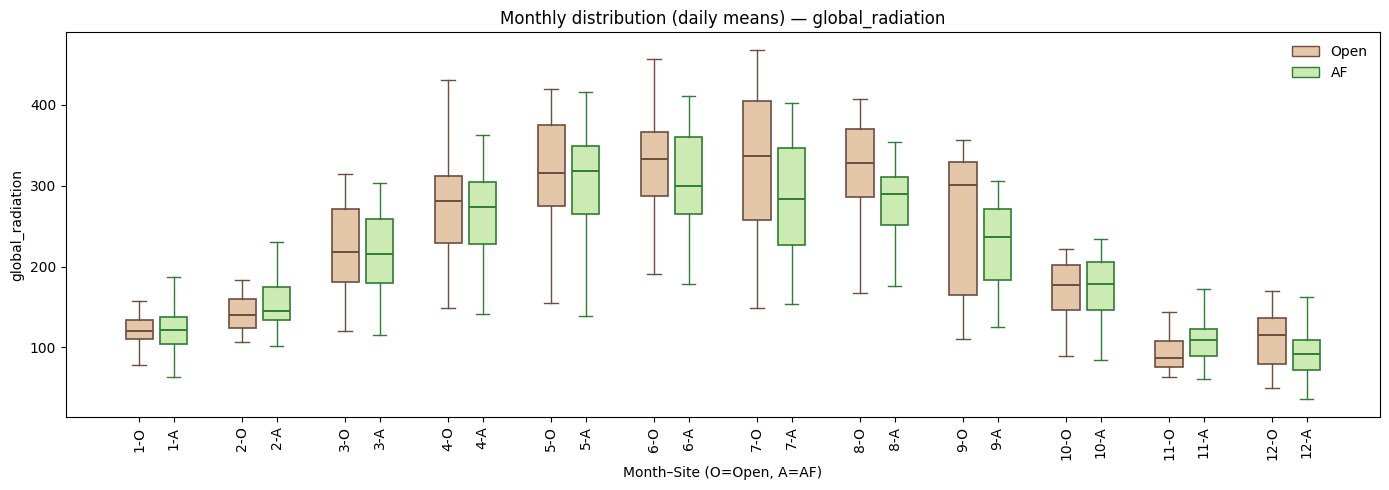

Saved: fig_q1/q1_box_month_global_radiation.png and fig_q1/q1_box_month_global_radiation.pdf


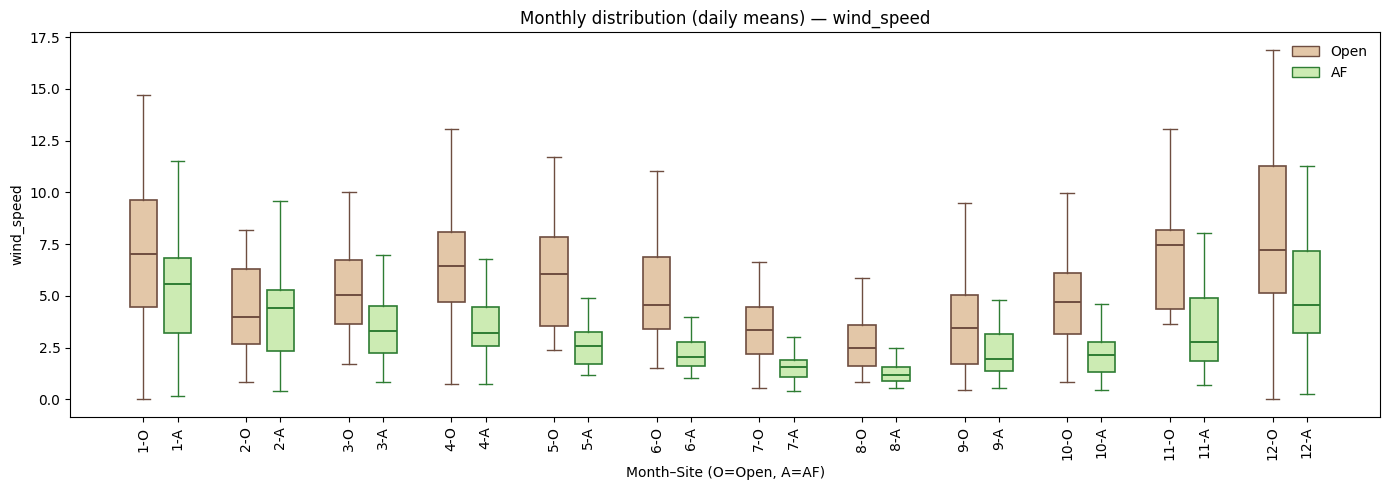

Saved: fig_q1/q1_box_month_wind_speed.png and fig_q1/q1_box_month_wind_speed.pdf


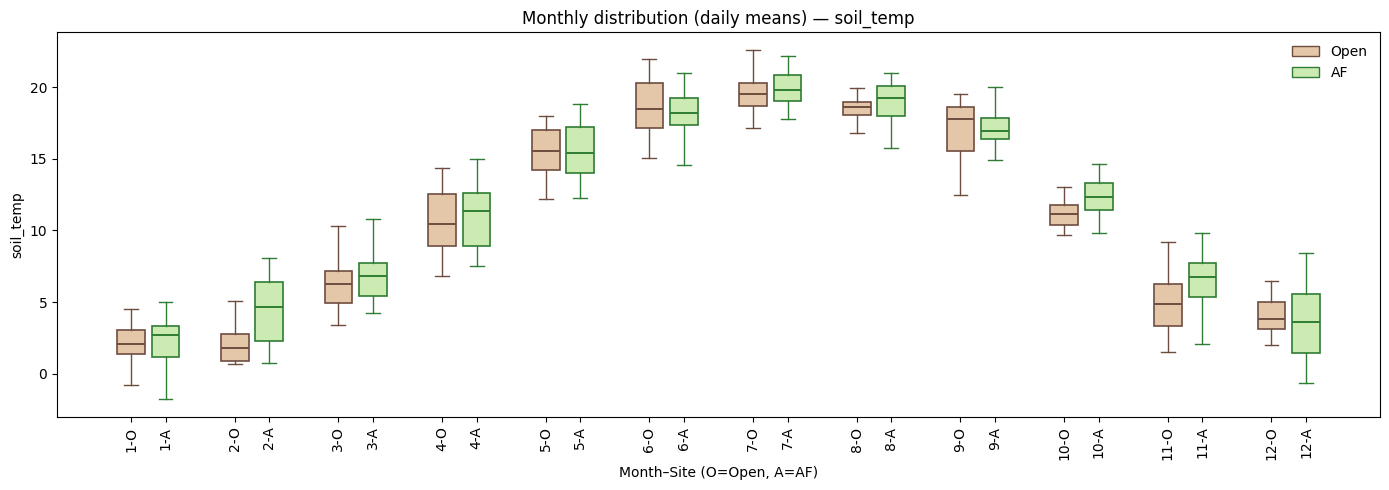

Saved: fig_q1/q1_box_month_soil_temp.png and fig_q1/q1_box_month_soil_temp.pdf


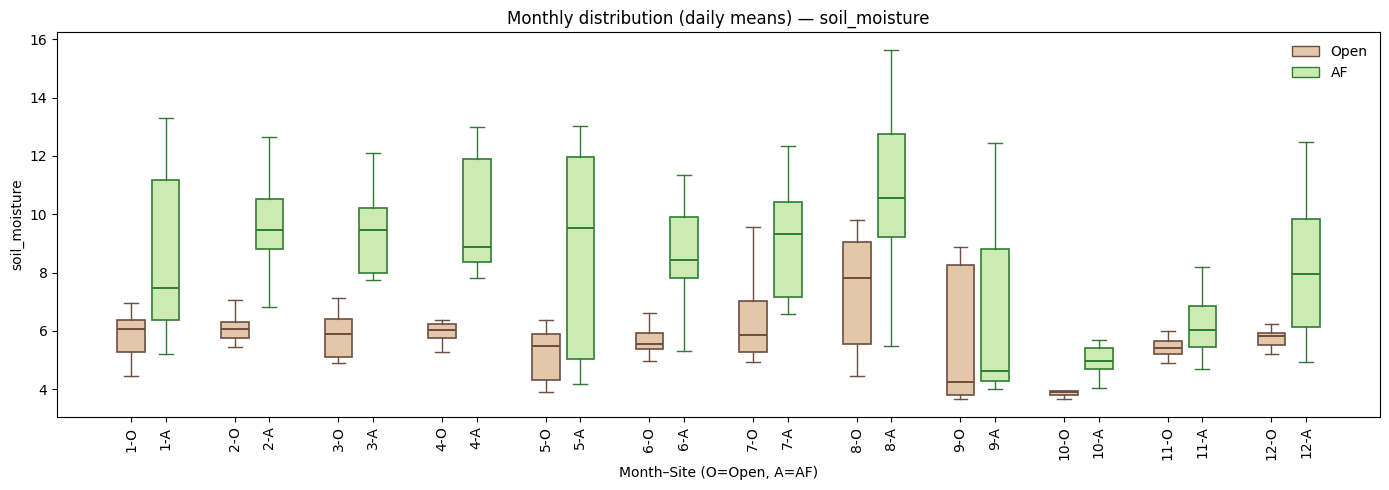

Saved: fig_q1/q1_box_month_soil_moisture.png and fig_q1/q1_box_month_soil_moisture.pdf


In [22]:
# --- Month-wise boxplots (AF=light green, Open=light brown) for ALL key vars ---
# Vars covered: air_temp, vpd, global_radiation, wind_speed, soil_temp (pooled), soil_moisture (pooled)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ---------- Colors ----------
AF_FILL   = (0.80, 0.92, 0.70, 1.0)  # light green
AF_EDGE   = (0.18, 0.49, 0.20, 1.0)  # dark green
OPEN_FILL = (0.89, 0.78, 0.66, 1.0)  # light brown/tan
OPEN_EDGE = (0.43, 0.30, 0.25, 1.0)  # dark brown

# ---------- Safety nets (if cell is run standalone) ----------
try:
    NUM_VARS
except NameError:
    # requires var_map from mapping cell
    NUM_VARS = {k: v for k, v in var_map.items() if v is not None and k != "wind_dir"}

if 'daily' not in globals():
    # requires df with _ts, _site and mapped columns in NUM_VARS
    mask_known = df["_site"].astype(str).isin(["AF", "Open"])
    df_use = df[mask_known].copy() if mask_known.sum() >= 100 else df.copy()
    for k, col in NUM_VARS.items():
        df_use[col] = pd.to_numeric(df_use[col], errors="coerce")
    df_use["_date"] = df_use["_ts"].dt.floor("D")
    daily = df_use.groupby(["_date", "_site"], dropna=False).agg(
        {col: "mean" for col in NUM_VARS.values()}
    ).reset_index()

# Aliases for depth families
ALIASES = {
    "soil_moisture": ["soil_moisture_0", "soil_moisture_1"],
    "soil_temp":     ["soil_temp_0",     "soil_temp_1"],
}

def _resolve_keys(var_key, num_vars):
    if var_key in num_vars:
        return [var_key]
    return [k for k in ALIASES.get(var_key, []) if k in num_vars]

def _ensure_dir(path):
    if path and not os.path.isdir(path):
        os.makedirs(path, exist_ok=True)

def _paint_boxplot(bp, fill, edge):
    for b in bp["boxes"]:
        b.set_facecolor(fill); b.set_edgecolor(edge); b.set_linewidth(1.2)
    for m in bp["medians"]:
        m.set_color(edge); m.set_linewidth(1.4)
    for w in bp["whiskers"]:
        w.set_color(edge); w.set_linewidth(1.0)
    for c in bp["caps"]:
        c.set_color(edge); c.set_linewidth(1.0)

def _pooled_column(daily_df, var_key, num_vars):
    """
    For soil_moisture/soil_temp: pool depth-0 and depth-1 daily means into a single column
    (row-wise mean ignoring NaN). Returns (colname_to_use, tmp_series_or_None).
    For single vars: just return mapped column and None.
    """
    if var_key in ("soil_moisture", "soil_temp"):
        depth_keys = _resolve_keys(var_key, num_vars)
        if not depth_keys:
            return None, None
        cols = [num_vars[k] for k in depth_keys if num_vars.get(k) in daily_df.columns]
        if not cols:
            return None, None
        pooled_col = f"__pooled_{var_key}"
        tmp = daily_df[cols].mean(axis=1, skipna=True)
        return pooled_col, tmp
    # simple var
    col = num_vars.get(var_key)
    if col and col in daily_df.columns:
        return col, None
    return None, None

def plot_month_boxplots_all(daily_df, outdir="fig_q1", dpi=300):
    """
    Makes colored month boxplots for:
      - air_temp
      - vpd
      - global_radiation
      - wind_speed (mean)
      - soil_temp (pooled depths)
      - soil_moisture (pooled depths)
    """
    _ensure_dir(outdir)

    VAR_KEYS = ["air_temp", "vpd", "global_radiation", "wind_speed", "soil_temp", "soil_moisture"]

    for var_key in VAR_KEYS:
        col, pooled_series = _pooled_column(daily_df, var_key, NUM_VARS)
        if col is None:
            print(f"Skip {var_key}: not detected.")
            continue

        dsub = daily_df.copy()
        if pooled_series is not None:
            dsub[col] = pd.to_numeric(pooled_series, errors="coerce")

        # AF/Open only (if available)
        mask = dsub["_site"].isin(["AF","Open"])
        if mask.any():
            dsub = dsub[mask].copy()

        dsub = dsub.dropna(subset=[col])
        if dsub.empty:
            print(f"Skip {var_key}: no data.")
            continue

        dsub["_month"] = pd.to_datetime(dsub["_date"]).dt.month
        months = [m for m in range(1, 12+1) if ((dsub["_month"] == m) & dsub["_site"].isin(["AF","Open"])).any()]
        if not months:
            print(f"Skip {var_key}: no monthly AF/Open data.")
            continue

        # Build data and positions
        data_open, data_af = [], []
        pos_open, pos_af, labels = [], [], []
        for i, m in enumerate(months, start=1):
            vo = pd.to_numeric(dsub.loc[(dsub["_month"]==m) & (dsub["_site"]=="Open"), col], errors="coerce").dropna().values
            va = pd.to_numeric(dsub.loc[(dsub["_month"]==m) & (dsub["_site"]=="AF"),   col], errors="coerce").dropna().values
            data_open.append(vo if vo.size else np.array([]))
            data_af.append(va if va.size else np.array([]))
            base = 3*i
            pos_open.append(base - 2)  # Open
            pos_af.append(base - 1)    # AF
            labels.extend([f"{m}-O", f"{m}-A"])

        fig, ax = plt.subplots(figsize=(14, 5))

        # Open (brown)
        bp_open = ax.boxplot(
            data_open,
            positions=pos_open,
            widths=0.8,
            showfliers=False,
            patch_artist=True,
            manage_ticks=False,
            boxprops=dict(facecolor=OPEN_FILL, edgecolor=OPEN_EDGE, linewidth=1.2),
            medianprops=dict(color=OPEN_EDGE, linewidth=1.4),
            whiskerprops=dict(color=OPEN_EDGE, linewidth=1.0),
            capprops=dict(color=OPEN_EDGE, linewidth=1.0),
        )
        _paint_boxplot(bp_open, OPEN_FILL, OPEN_EDGE)

        # AF (green)
        bp_af = ax.boxplot(
            data_af,
            positions=pos_af,
            widths=0.8,
            showfliers=False,
            patch_artist=True,
            manage_ticks=False,
            boxprops=dict(facecolor=AF_FILL, edgecolor=AF_EDGE, linewidth=1.2),
            medianprops=dict(color=AF_EDGE, linewidth=1.4),
            whiskerprops=dict(color=AF_EDGE, linewidth=1.0),
            capprops=dict(color=AF_EDGE, linewidth=1.0),
        )
        _paint_boxplot(bp_af, AF_FILL, AF_EDGE)

        # Axes/legend
        xticks = [v for pair in zip(pos_open, pos_af) for v in pair]
        ax.set_xticks(xticks)
        ax.set_xticklabels(labels, rotation=90)
        ax.set_xlabel("Month–Site (O=Open, A=AF)")
        ax.set_ylabel(var_key)
        ax.set_title(f"Monthly distribution (daily means) — {var_key}")

        legend_handles = [
            mpatches.Patch(facecolor=OPEN_FILL, edgecolor=OPEN_EDGE, label="Open"),
            mpatches.Patch(facecolor=AF_FILL,   edgecolor=AF_EDGE,   label="AF"),
        ]
        ax.legend(handles=legend_handles, loc="best", frameon=False)

        # Save
        png = os.path.join(outdir, f"q1_box_month_{var_key}.png")
        pdf = os.path.join(outdir, f"q1_box_month_{var_key}.pdf")
        fig.tight_layout()
        fig.savefig(png, dpi=300, bbox_inches="tight")
        fig.savefig(pdf, bbox_inches="tight")
        plt.show()
        print("Saved:", png, "and", pdf)

# ---- Run for all variables
plot_month_boxplots_all(daily, outdir="fig_q1", dpi=300)


,variable,contrast,n_days,mean_diff,ci95_lo,ci95_hi,p_perm,d_paired,q_fdr
0,air_temp,AF - Open,519,-2.029711,-2.287597,-1.767052,0.0005,-0.686271,0.0005
2,global_radiation,AF - Open,529,-16.872273,-19.406991,-14.275192,0.0005,-0.576793,0.0005
4,soil_moisture,AF - Open,527,3.189843,3.028609,3.347945,0.0005,1.636630,0.0005
5,soil_temp,AF - Open,524,0.277255,0.194225,0.359148,0.0005,0.291955,0.0005
1,vpd,AF - Open,488,-0.230405,-0.262120,-0.198335,0.0005,-0.630365,0.0005
3,wind_speed,AF - Open,529,-2.331041,-2.493567,-2.183895,0.0005,-1.268564,0.0005


Saved: q1_af_open_paired_summary.csv


,variable,month,n_days,mean_diff,ci95_lo,ci95_hi,p_perm,q_fdr
0,air_temp,1,46,-2.128018,-2.808853,-1.422889,0.000500,0.000720
1,air_temp,2,30,-5.376196,-6.198010,-4.564764,0.000500,0.000720
2,air_temp,3,61,-1.957671,-2.713712,-1.234154,0.000500,0.000720
3,air_temp,4,47,-1.763282,-2.618436,-0.865835,0.000500,0.000720
4,air_temp,5,41,-3.372669,-4.031489,-2.636475,0.000500,0.000720
5,air_temp,6,57,-1.994115,-2.606741,-1.391192,0.000500,0.000720
6,air_temp,7,62,-2.397123,-3.058640,-1.771251,0.000500,0.000720
7,air_temp,8,62,-2.542119,-3.256660,-1.859110,0.000500,0.000720
8,air_temp,9,31,-1.700109,-3.181801,0.047894,0.041979,0.049549
9,air_temp,10,20,0.560045,0.469096,0.662762,0.000500,0.000720


Saved: q1_af_open_paired_by_month.csv


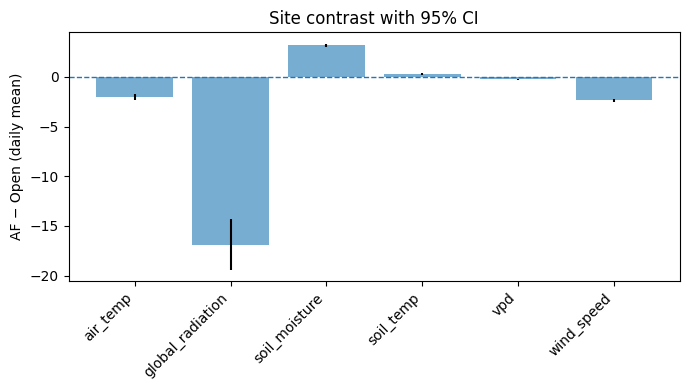

Saved: q1_effect_bars.png


In [14]:
# === Q1 stats: AF vs Open (paired daily differences, bootstrap CI, permutation p, BH–FDR) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(RANDOM_SEED)

# Which high-level variables to test (will resolve to actual columns or composites)
TEST_KEYS = ["air_temp", "vpd", "global_radiation", "wind_speed", "soil_moisture", "soil_temp"]

def _ensure_column_for(daily_df, var_key, var_map):
    """
    Returns (work_df, col_name) where work_df contains the column to test.
    If a composite isn't present, builds it on the fly (e.g., mean of 0/1 depths).
    """
    d = daily_df.copy()
    # direct mapping exists and column present
    col = var_map.get(var_key)
    if col and col in d.columns:
        return d, col

    # else try depth pairs on the daily table
    def _maybe_build(c0, c1, out):
        if (c0 in d.columns) and (c1 in d.columns):
            d[out] = d[[c0, c1]].mean(axis=1)
            return out
        # single-depth fallback
        if c0 in d.columns:
            return c0
        if c1 in d.columns:
            return c1
        return None

    if var_key == "soil_moisture":
        col = _maybe_build(var_map.get("soil_moisture_0"), var_map.get("soil_moisture_1"),
                           "soil_moisture__mean2")
    elif var_key == "soil_temp":
        col = _maybe_build(var_map.get("soil_temp_0"), var_map.get("soil_temp_1"),
                           "soil_temp__mean2")
    else:
        # last resort: if var_map maps to something present in original df, try it
        col = var_map.get(var_key)

    return d, col if col in d.columns else (d, None)[1]

def _paired_perm_p(diffs, reps=2000, seed=123):
    diffs = np.asarray(diffs, dtype=float)
    diffs = diffs[~np.isnan(diffs)]
    n = diffs.size
    if n < 5:
        return np.nan
    rr = np.random.default_rng(seed)
    T_obs = diffs.mean()
    signs = rr.choice([-1, 1], size=(reps, n))
    T_perm = (diffs * signs).mean(axis=1)
    p = (np.abs(T_perm) >= abs(T_obs)).mean()
    # small sample correction
    return (p * reps + 1) / (reps + 1)

def _bootstrap_ci(diffs, B=2000, seed=123):
    diffs = np.asarray(diffs, dtype=float)
    diffs = diffs[~np.isnan(diffs)]
    n = diffs.size
    if n < 5:
        return (np.nan, np.nan)
    rr = np.random.default_rng(seed)
    idx = rr.integers(0, n, size=(B, n))
    boot = diffs[idx].mean(axis=1)
    return (np.percentile(boot, 2.5), np.percentile(boot, 97.5))

def _bh_fdr(pdict):
    items = [(k, v) for k, v in pdict.items() if np.isfinite(v)]
    m = len(items)
    if m == 0:
        return {k: np.nan for k in pdict}
    items.sort(key=lambda kv: kv[1])
    q = {}
    min_so_far = 1.0
    for rank, (name, p) in enumerate(reversed(items), start=1):
        i = m - rank + 1
        qv = min(min_so_far, (m / i) * p)
        q[name] = qv
        min_so_far = qv
    # map back
    return {k: q.get(k, np.nan) for k in pdict}

# Restrict to AF/Open days if available
have_af_open = daily["_site"].isin(["AF","Open"]).any()
D = daily if not have_af_open else daily[daily["_site"].isin(["AF","Open"])].copy()

rows = []
pvals = {}

for key in TEST_KEYS:
    dwork, col = _ensure_column_for(D, key, var_map)
    if not col:
        print(f"[skip] {key}: no usable column.")
        continue

    pivot = dwork.pivot_table(index="_date", columns="_site", values=col, aggfunc="mean")
    if not {"AF", "Open"}.issubset(pivot.columns):
        print(f"[skip] {key}: need both AF & Open.")
        continue

    diffs = (pivot["AF"] - pivot["Open"]).dropna().values
    n = diffs.size
    if n < 5:
        md, lo, hi, p, d = (np.nan,)*5
    else:
        md = float(diffs.mean())
        lo, hi = _bootstrap_ci(diffs, B=BOOTSTRAP_B, seed=RANDOM_SEED)
        p = _paired_perm_p(diffs, reps=PERM_REPS, seed=RANDOM_SEED)
        # paired effect size (standardized mean of differences)
        d = float(md / (np.std(diffs, ddof=1) if np.std(diffs, ddof=1) > 0 else np.nan))

    pvals[key] = p
    rows.append({
        "variable": key,
        "contrast": "AF - Open",
        "n_days": int(n),
        "mean_diff": md,
        "ci95_lo": lo,
        "ci95_hi": hi,
        "p_perm": p,
        "d_paired": d
    })

# FDR correction across variables
qvals = _bh_fdr(pvals)
for r in rows:
    r["q_fdr"] = qvals.get(r["variable"], np.nan)

summary = pd.DataFrame(rows).sort_values("variable")
display(summary)
summary.to_csv("q1_af_open_paired_summary.csv", index=False)
print("Saved: q1_af_open_paired_summary.csv")

# --- Optional: by-month breakdown (paired within month) ---
by_month = []
for key in TEST_KEYS:
    dwork, col = _ensure_column_for(D, key, var_map)
    if not col:
        continue
    dwork["_month"] = pd.to_datetime(dwork["_date"]).dt.month
    for m, g in dwork.groupby("_month"):
        pv = g.pivot_table(index="_date", columns="_site", values=col, aggfunc="mean")
        if not {"AF","Open"}.issubset(pv.columns):
            continue
        diffs = (pv["AF"] - pv["Open"]).dropna().values
        n = diffs.size
        if n < 5:
            md, lo, hi, p = (np.nan,)*4
        else:
            md = float(diffs.mean())
            lo, hi = _bootstrap_ci(diffs, B=BOOTSTRAP_B, seed=RANDOM_SEED)
            p = _paired_perm_p(diffs, reps=PERM_REPS, seed=RANDOM_SEED)
        by_month.append({"variable": key, "month": int(m), "n_days": int(n),
                         "mean_diff": md, "ci95_lo": lo, "ci95_hi": hi, "p_perm": p})

by_month = pd.DataFrame(by_month)
if not by_month.empty:
    # FDR across all (var,month) tests
    q_map = _bh_fdr({(r.variable, r.month): r.p_perm for r in by_month.itertuples()})
    by_month["q_fdr"] = [q_map.get((r.variable, r.month), np.nan) for r in by_month.itertuples()]
    display(by_month.sort_values(["variable","month"]))
    by_month.to_csv("q1_af_open_paired_by_month.csv", index=False)
    print("Saved: q1_af_open_paired_by_month.csv")

# --- Optional quick effect barplot (overall) ---
plt.figure(figsize=(7,4))
plot_df = summary.dropna(subset=["mean_diff"])
x = np.arange(len(plot_df))
plt.axhline(0, linestyle="--", linewidth=1)
plt.bar(x, plot_df["mean_diff"].values, yerr=[plot_df["mean_diff"]-plot_df["ci95_lo"],
                                              plot_df["ci95_hi"]-plot_df["mean_diff"]],
        alpha=0.6)
plt.xticks(x, plot_df["variable"].values, rotation=45, ha="right")
plt.ylabel("AF − Open (daily mean)")
plt.title("Site contrast with 95% CI")
plt.tight_layout(); plt.savefig("q1_effect_bars.png", dpi=300); plt.show()
print("Saved: q1_effect_bars.png")


In [28]:
# @title Daily means by site (for pairing AF vs Open) — NODE-EQUAL

# 1) Keep AF/Open only if present in reasonable numbers; else keep all
mask_known = df["_site"].astype(str).isin(["AF", "Open"])
df_use = df.loc[mask_known].copy() if mask_known.sum() >= 100 else df.copy()

# 2) Variables to aggregate: take columns from var_map (exclude None and wind_dir)
use_cols = [col for k, col in var_map.items() if (col is not None and k != "wind_dir")]
use_cols = sorted(dict.fromkeys(use_cols))  # unique, stable order

# 3) Ensure datetime day key
df_use["_date"] = pd.to_datetime(df_use["_ts"], errors="coerce").dt.floor("D")

# --- Choose node column (needed for node-equal averaging)
node_col = "node" if "node" in df_use.columns else ("node_id" if "node_id" in df_use.columns else None)
if node_col is None:
    raise ValueError("No 'node' or 'node_id' column found; required for node-equal daily means.")

# 4) Coerce chosen columns to numeric (others untouched)
for col in use_cols:
    df_use[col] = pd.to_numeric(df_use[col], errors="coerce")

# 5) NODE-EQUAL daily means:
#    (a) per-node/day means, then (b) per-site/day mean of those node means
node_daily = (
    df_use[["_date", "_site", node_col] + use_cols]
      .groupby(["_date", "_site", node_col], dropna=False, as_index=False)
      .mean(numeric_only=True)
)

# Optional: how many nodes contributed per site-day (handy for QC/plots later)
node_counts = (
    node_daily.groupby(["_date", "_site"], dropna=False)[node_col]
              .nunique()
              .rename("n_nodes")
              .reset_index()
)

daily = (
    node_daily.groupby(["_date", "_site"], dropna=False, as_index=False)
              .mean(numeric_only=True)
              .merge(node_counts, on=["_date","_site"], how="left")
)

# 6) Quick look
display(daily.head())
print("Daily rows per site:")
display(daily["_site"].value_counts(dropna=False).to_frame("rows"))

# 7) Coverage snapshot (share of non-missing per site across all rows pre-aggregation)
cov = (
    df_use.groupby("_site")[use_cols]
    .apply(lambda g: g.notna().mean().rename("non_null_share"))
    .unstack(0)
    .round(3)
)
print("Non-null share by variable and site (0–1):")
display(cov)

# 8) Save (distinct name to reflect node-equal)
DAILY_OUT = "q1_daily_means_by_site_nodeeq.csv"
daily.to_csv(DAILY_OUT, index=False)
print("Saved:", DAILY_OUT)


,_date,_site,_vpd_calc,global_radiation__pref,ground_humidity_0__pref,ground_humidity_1__pref,ground_temp_0__pref,ground_temp_1__pref,humidity__pref,soil_moisture__pref,soil_temp__pref,temperature__pref,wind_speed_mean__pref,n_nodes
0,2023-10-30,AF,0.264380,84.374964,7.614783,6.578188,9.985761,9.960688,82.919565,7.096486,9.973225,12.617065,2.147246,6
1,2023-10-30,Open,0.261278,89.004348,4.481739,9.369348,10.010870,9.466739,82.426087,6.925543,9.738804,12.307174,3.135217,1
2,2023-10-31,AF,0.204753,89.601333,7.589214,6.469608,9.930542,9.763686,84.923300,7.029411,9.847114,11.281936,4.584915,6
3,2023-10-31,Open,0.189150,91.515957,4.250957,9.233830,9.967553,9.423617,85.443617,6.742394,9.695585,10.748511,9.255745,1
4,2023-11-01,AF,0.264387,69.699839,7.404587,6.182089,9.647919,9.344530,77.694686,6.793338,9.496224,9.044949,2.423498,6


Daily rows per site:


,rows
_site,
AF,672
Open,531


Non-null share by variable and site (0–1):


non_null_share           _site
_vpd_calc                AF       0.387
                         Open     0.851
global_radiation__pref   AF       0.998
                         Open     1.000
ground_humidity_0__pref  AF       0.900
                         Open     0.993
ground_humidity_1__pref  AF       0.940
                         Open     0.993
ground_temp_0__pref      AF       0.880
                         Open     0.961
ground_temp_1__pref      AF       0.919
                         Open     0.947
humidity__pref           AF       0.387
                         Open     0.852
soil_moisture__pref      AF       0.982
                         Open     0.993
soil_temp__pref          AF       0.976
                         Open     0.977
temperature__pref        AF       0.976
                         Open     0.980
wind_speed_mean__pref    AF       1.000
                         Open     1.000
dtype: float64

Saved: q1_daily_means_by_site_nodeeq.csv


In [30]:
# === Year check USING COMPOSITE daily means (soil vars averaged over _0/_1 per site/day) ===
import numpy as np
import pandas as pd
import os

# ---- defaults (safe if already defined) ----
RANDOM_SEED = globals().get("RANDOM_SEED", 123)
BOOTSTRAP_B = globals().get("BOOTSTRAP_B", 2000)
PERM_REPS   = globals().get("PERM_REPS", 2000)
rng = np.random.default_rng(RANDOM_SEED)

def paired_permutation_pvalue(diffs, reps=2000, seed=123):
    r = np.random.default_rng(seed)
    d = np.asarray(diffs, dtype=float)
    d = d[~np.isnan(d)]
    n = d.size
    if n < 5:
        return np.nan
    T_obs = d.mean()
    signs = r.choice([-1, 1], size=(reps, n))
    T_perm = (d * signs).mean(axis=1)
    p = (np.abs(T_perm) >= abs(T_obs)).mean()
    return (p * reps + 1) / (reps + 1)

def _ci_bootstrap_mean(vals, B=2000, seed=123, q=(2.5, 97.5)):
    v = np.asarray(vals, dtype=float)
    v = v[~np.isnan(v)]
    n = v.size
    if n == 0:
        return (np.nan, np.nan)
    r = np.random.default_rng(seed)
    idx = r.integers(0, n, size=(B, n))
    m = v[idx].mean(axis=1)
    lo, hi = np.percentile(m, list(q))
    return float(lo), float(hi)

def benjamini_hochberg(pdict):
    items = [(k, v) for k, v in pdict.items() if np.isfinite(v)]
    m = len(items)
    if m == 0:
        return {k: np.nan for k in pdict}
    items.sort(key=lambda kv: kv[1])
    qvals = {}
    min_so_far = 1.0
    for rank, (name, p) in enumerate(reversed(items), start=1):
        i = m - rank + 1
        q = min(min_so_far, (m / i) * p)
        qvals[name] = q
        min_so_far = q
    return {k: qvals.get(k, np.nan) for k, _ in pdict.items()}

# ---- 0) Build composite columns in *daily* (site/day level), averaging the two soil probes ----
# We’ll look up which columns daily actually has based on your var_map.
def _daily_add_composite_mean(daily_df, cols, out_name):
    present = [c for c in cols if c and c in daily_df.columns]
    if not present:
        return
    arr = np.column_stack([pd.to_numeric(daily_df[c], errors="coerce").values for c in present])
    daily_df[out_name] = np.nanmean(arr, axis=1)

# Figure out which column names represent the two soil probes *in daily*
sm0 = var_map.get("soil_moisture_0")
sm1 = var_map.get("soil_moisture_1")
st0 = var_map.get("soil_temp_0")
st1 = var_map.get("soil_temp_1")

# Create composite columns (adds columns if inputs exist)
daily = daily.copy()
_daily_add_composite_mean(daily, [sm0, sm1], "soil_moisture__pref")
_daily_add_composite_mean(daily, [st0, st1], "soil_temp__pref")

# ---- 1) Build the per-variable column map for the year-check (use composites for soil) ----
YEAR_VARS = {}  # var_key -> column name in daily

def _maybe_map(var_key, col_name):
    if col_name and (col_name in daily.columns):
        YEAR_VARS[var_key] = col_name

# Single-channel vars (take from var_map; they were aggregated into daily with same names)
_m = var_map  # shorthand
_maybe_map("air_temp",         _m.get("air_temp"))          # e.g., "temperature__pref"
_maybe_map("rh",               _m.get("rh"))                # e.g., "humidity__pref"
_maybe_map("vpd",              _m.get("vpd"))               # e.g., "_vpd_calc"
_maybe_map("global_radiation", _m.get("global_radiation"))  # e.g., "global_radiation__pref/clean"
_maybe_map("wind_speed",       _m.get("wind_speed"))        # e.g., "wind_speed_mean__pref/clean"
_maybe_map("air_pressure",     _m.get("air_pressure"))      # if present

# Soil composites (use the newly added per-site/day means)
_maybe_map("soil_moisture", "soil_moisture__pref")
_maybe_map("soil_temp",     "soil_temp__pref")

# Drop wind_dir if it sneaks in
YEAR_VARS.pop("wind_dir", None)

print("[year-check] Variables (using composites for soil):", YEAR_VARS)

# ---- 2) Restrict to AF/Open and prepare date parts ----
d0 = daily.copy()
d0["_date"] = pd.to_datetime(d0["_date"])
d0 = d0[d0["_site"].isin(["AF", "Open"])].copy()

per_year_rows = []
overall_rows  = []
p_overall, p_hetero = {}, {}

# ---- 3) Per-variable month-overlap (per var) + tests ----
for var_key, col in YEAR_VARS.items():
    if col not in d0.columns:
        continue

    piv = d0.pivot_table(index="_date", columns="_site", values=col, aggfunc="mean")
    piv2 = piv.dropna(subset=["AF", "Open"], how="any").copy()
    if piv2.empty:
        continue
    piv2["year"]  = piv2.index.year
    piv2["month"] = piv2.index.month

    years_avail = sorted(piv2["year"].unique().tolist())
    month_sets = [set(piv2.loc[piv2["year"] == y, "month"].unique()) for y in years_avail]
    common_months = set.intersection(*month_sets) if month_sets else set()

    if not common_months:
        piv_use = piv2.copy()
        months_used_label = "ALL"
    else:
        piv_use = piv2[piv2["month"].isin(sorted(common_months))].copy()
        months_used_label = ",".join(map(str, sorted(common_months)))

    # Overall pooled effect AF−Open
    diffs_all = (piv_use["AF"] - piv_use["Open"]).to_numpy()
    overall_mean = float(np.nanmean(diffs_all)) if diffs_all.size else np.nan
    overall_ci_lo, overall_ci_hi = _ci_bootstrap_mean(diffs_all, B=BOOTSTRAP_B, seed=RANDOM_SEED)
    overall_p = paired_permutation_pvalue(diffs_all, reps=PERM_REPS, seed=RANDOM_SEED)
    p_overall[var_key] = overall_p

    # Per-year summaries
    for y, g in piv_use.groupby("year", sort=True):
        diffs_y = (g["AF"] - g["Open"]).to_numpy()
        n_y = int(np.isfinite(diffs_y).sum())
        if n_y == 0:
            continue
        mean_y = float(np.nanmean(diffs_y))
        lo_y, hi_y = _ci_bootstrap_mean(diffs_y, B=BOOTSTRAP_B, seed=RANDOM_SEED)
        p_y = paired_permutation_pvalue(diffs_y, reps=PERM_REPS, seed=RANDOM_SEED)
        per_year_rows.append({
            "variable": var_key,
            "year": int(y),
            "months_used": months_used_label,
            "n_days": n_y,
            "mean_diff_AF_minus_Open": mean_y,
            "ci95_lo": lo_y,
            "ci95_hi": hi_y,
            "p_perm_year": p_y,
        })

    # Heterogeneity across years (variance of per-year means vs within-year sign flips)
    per_year = piv_use.assign(delta=piv_use["AF"] - piv_use["Open"]) \
                      .groupby("year")["delta"].apply(lambda s: s.values)
    years_h = per_year.index.to_list()
    if len(years_h) >= 2:
        means_obs = np.array([np.nanmean(per_year[y]) for y in years_h], dtype=float)
        T_obs = float(np.nanvar(means_obs, ddof=0))
        T_perm = np.empty(PERM_REPS, dtype=float)
        for b in range(PERM_REPS):
            means_b = []
            for y in years_h:
                d = np.asarray(per_year[y], dtype=float)
                sgn = rng.choice([-1, 1], size=d.size)
                means_b.append(np.mean(d * sgn))
            T_perm[b] = np.var(means_b, ddof=0)
        p_het = float((T_perm >= T_obs).mean())
        p_het = (p_het * PERM_REPS + 1) / (PERM_REPS + 1)
    else:
        T_obs = np.nan
        p_het = np.nan
    p_hetero[var_key] = p_het

    overall_rows.append({
        "variable": var_key,
        "months_used": months_used_label,
        "n_years": int(len(years_avail)),
        "n_days_total": int(np.isfinite(diffs_all).sum()),
        "mean_diff_AF_minus_Open": overall_mean,
        "ci95_lo": overall_ci_lo,
        "ci95_hi": overall_ci_hi,
        "p_perm_overall": overall_p,
        "heterogeneity_stat_var_means": T_obs,
        "p_perm_heterogeneity": p_het,
    })

# ---- 4) FDR across variables ----
q_overall = benjamini_hochberg(p_overall)
q_hetero  = benjamini_hochberg(p_hetero)

overall_df = pd.DataFrame(overall_rows).sort_values("variable")
if not overall_df.empty:
    overall_df["q_fdr_overall"] = overall_df["variable"].map(q_overall)
    overall_df["q_fdr_heterogeneity"] = overall_df["variable"].map(q_hetero)

per_year_df = pd.DataFrame(per_year_rows).sort_values(["variable", "year"])

print("\n=== Year-check (composite soil) — OVERALL pooled AF−Open ===")
display(overall_df)

print("\n=== Year-check (composite soil) — PER YEAR AF−Open ===")
display(per_year_df)

# ---- 5) Save CSVs ----
os.makedirs("q1_year_checks", exist_ok=True)
overall_path = os.path.join("q1_year_checks", "yearcheck_COMPOSITE_pervar_overlap_overall.csv")
peryear_path = os.path.join("q1_year_checks", "yearcheck_COMPOSITE_pervar_overlap_peryear.csv")
overall_df.to_csv(overall_path, index=False)
per_year_df.to_csv(peryear_path, index=False)
print("Saved:", overall_path)
print("Saved:", peryear_path)


/tmp/ipython-input-1417469709.py:59: RuntimeWarning: Mean of empty slice
  daily_df[out_name] = np.nanmean(arr, axis=1)


[year-check] Variables (using composites for soil): {'air_temp': 'temperature__pref', 'rh': 'humidity__pref', 'vpd': '_vpd_calc', 'global_radiation': 'global_radiation__pref', 'wind_speed': 'wind_speed_mean__pref', 'soil_moisture': 'soil_moisture__pref', 'soil_temp': 'soil_temp__pref'}

=== Year-check (composite soil) — OVERALL pooled AF−Open ===


,variable,months_used,n_years,n_days_total,mean_diff_AF_minus_Open,ci95_lo,ci95_hi,p_perm_overall,heterogeneity_stat_var_means,p_perm_heterogeneity,q_fdr_overall,q_fdr_heterogeneity
0,air_temp,ALL,3,519,-2.042430,-2.300412,-1.777148,0.0005,6.068876,0.000500,0.0005,0.000583
3,global_radiation,ALL,3,529,-17.276710,-19.891063,-14.631222,0.0005,38.021454,0.000500,0.0005,0.000583
1,rh,ALL,3,489,10.474073,9.478465,11.415998,0.0005,49.061169,0.000500,0.0005,0.000583
5,soil_moisture,ALL,3,527,3.609778,3.418775,3.796353,0.0005,2.285645,0.000500,0.0005,0.000583
6,soil_temp,ALL,3,524,0.377873,0.260422,0.474368,0.0005,0.326310,0.000500,0.0005,0.000583
2,vpd,ALL,3,488,-0.290544,-0.324193,-0.256491,0.0005,0.055931,0.000500,0.0005,0.000583
4,wind_speed,ALL,3,529,-2.348650,-2.505571,-2.200992,0.0005,0.051271,0.491754,0.0005,0.491754



=== Year-check (composite soil) — PER YEAR AF−Open ===


,variable,year,months_used,n_days,mean_diff_AF_minus_Open,ci95_lo,ci95_hi,p_perm_year
0,air_temp,2023,ALL,35,0.559278,0.438843,0.685517,0.000500
1,air_temp,2024,ALL,236,0.407401,0.252788,0.602212,0.000500
2,air_temp,2025,ALL,248,-4.740897,-4.926293,-4.540333,0.000500
9,global_radiation,2023,ALL,35,-6.827989,-8.806633,-4.889048,0.000500
10,global_radiation,2024,ALL,246,-14.074360,-18.353531,-9.803261,0.000500
11,global_radiation,2025,ALL,248,-21.927852,-25.337286,-18.496460,0.000500
3,rh,2023,ALL,35,0.179887,-0.480196,0.843946,0.597201
4,rh,2024,ALL,212,4.918512,3.913270,5.886571,0.000500
5,rh,2025,ALL,242,16.829757,15.427151,18.148459,0.000500
15,soil_moisture,2023,ALL,35,1.572971,1.190972,2.059934,0.000500


Saved: q1_year_checks/yearcheck_COMPOSITE_pervar_overlap_overall.csv
Saved: q1_year_checks/yearcheck_COMPOSITE_pervar_overlap_peryear.csv
